## Severity: Main Modelling



In [1]:
from groo.groo import get_root
root_dir = get_root(".root_dir_covid")
import os
os.chdir(root_dir)
import sys
sys.path.append(os.path.join(root_dir, "covid-fear", "scripts"))

import numpy as np
import pandas as pd
from cov_functions import *
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import bambi as bmb
import arviz as az
import json
import pickle
#import cov_model_management as mm
sys.path.append(os.path.join(root_dir, "covid-fear", "lib")) 
import bammm.bammm as mm
import patsy
from IPython import display

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


$$
\alpha
$$

In [2]:
# data import
df = pd.read_csv(os.path.join(root_dir, "data", "full_dataset_only_complete.csv"))
# hyperparameters
corr_type = "spearman" 
factors =[ "F1_Close_Person_Worry","F2_Anxiety_Avoidance", "F3_Economic_Impact_Worry", "F4_Prob_Estimates", "F5_Worry", "F6_Skepticism"]
trait_factor_names = ["TF1_Self_Consciousness", "TF2_Positive", "TF3_Catastrophizing","TF4_Physiological_Anx", "TF5_Depression", "TF6_Cognitive_Anx"]

### How traits predict correlation of covid-state-measure and objective severity 

In [3]:
data = df.groupby(by="PROLIFICID")[["PROLIFICID", 'state_severity']+trait_factor_names].mean()

for f in factors:
    data["r_"+f] = np.nan
    for s in df["PROLIFICID"].unique():
        data["r_"+f][s] = df.loc[df["PROLIFICID"].isin([s])][["state_severity", f]].corr(corr_type).loc["state_severity"][f]
data

state_severity  TF1_Self_Consciousness  TF2_Positive  \
PROLIFICID                                                               
01S0stEpc3rU6YxK        1.154912               -0.913516      0.483572   
05c9AaLx1V20UAcO        0.976200               -0.256844     -1.943311   
07GDvN1Nh0oHcEBM        0.833057                0.196950     -0.270619   
0OjnLzK5ABd2wO54        0.135050               -2.244184     -0.528596   
0Pe1blVigsBRLvBj        1.316176               -0.338332     -0.107202   
...                          ...                     ...           ...   
zNbLeZqHa6wNHRLR        0.819378               -0.251153     -1.762307   
zYWr4nlB9BwdVWFB        1.928073               -0.549587     -0.014385   
zZGJnUM65XIz0F0X        0.183911               -0.535923     -0.463178   
zlOEoLWEAwlLTGbE        0.354648                0.111479      0.187209   
ztPVSoIVH3QKpGeQ        0.307537               -0.785927     -1.576438   

                  TF3_Catastrophizing  TF4_Physiological_Anx  TF5_Depression  \
PROLIFICID                                                                     
01S0stEpc3rU6YxK             0.776880              -1.206655       -0.823695   
05c9AaLx1V20UAcO            -0.625601               0.808114        1.042578   
07GDvN1Nh0oHcEBM             0.690942               0.357304       -0.783261   
0OjnLzK5ABd2wO54            -0.358472              -0.052033        0.200290   
0Pe1blVigsBRLvBj             0.687559               0.596735       -0.388884   
...                               ...                    ...             ...   
zNbLeZqHa6wNHRLR            -0.238505              -0.077690       -0.680727   
zYWr4nlB9BwdVWFB            -0.478398              -0.420884        1.255617   
zZGJnUM65XIz0F0X            -0.333601              -0.307800       -0.583521   
zlOEoLWEAwlLTGbE             0.787422               0.229965        0.892838   
ztPVSoIVH3QKpGeQ            -0.891628              -0.091140       -0.228383   

                  TF6_Cognitive_Anx  r_F1_Close_Person_Worry  \
PROLIFICID                                                     
01S0stEpc3rU6YxK           1.868218                 0.076197   
05c9AaLx1V20UAcO           0.322604                -0.347368   
07GDvN1Nh0oHcEBM          -0.024807                -0.424020   
0OjnLzK5ABd2wO54          -1.135049                 0.558105   
0Pe1blVigsBRLvBj           0.566922                 0.170175   
...                             ...                      ...   
zNbLeZqHa6wNHRLR          -1.184221                -0.069451   
zYWr4nlB9BwdVWFB           0.791164                 0.530827   
zZGJnUM65XIz0F0X          -0.096455                 0.210170   
zlOEoLWEAwlLTGbE           0.673904                 0.386466   
ztPVSoIVH3QKpGeQ           0.278212                 0.533133   

                  r_F2_Anxiety_Avoidance  r_F3_Economic_Impact_Worry  \
PROLIFICID                                                             
01S0stEpc3rU6YxK                0.172968                    0.031241   
05c9AaLx1V20UAcO               -0.524812                    0.654135   
07GDvN1Nh0oHcEBM               -0.191176                    0.186275   
0OjnLzK5ABd2wO54                0.520496                    0.691990   
0Pe1blVigsBRLvBj                0.082456                    0.082456   
...                                  ...                         ...   
zNbLeZqHa6wNHRLR               -0.066813                   -0.005275   
zYWr4nlB9BwdVWFB                0.096241                    0.267669   
zZGJnUM65XIz0F0X                0.234275                   -0.111488   
zlOEoLWEAwlLTGbE                0.381955                    0.630075   
ztPVSoIVH3QKpGeQ                0.153615                   -0.078313   

                  r_F4_Prob_Estimates  r_F5_Worry  r_F6_Skepticism  
PROLIFICID                                                          
01S0stEpc3rU6YxK            -0.044956    0.044194        -0.295645  
05c9AaLx1V20UAcO            -0.177444

#### look at correlations

<AxesSubplot:>

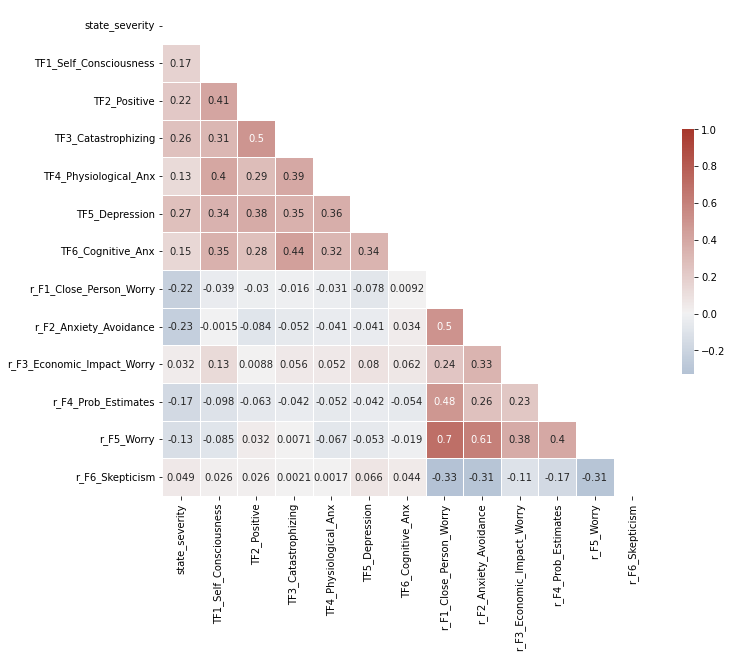

In [4]:

dfl = data.dropna()
# calculate correlation matrix
corr = dfl.corr(corr_type)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", 
                             as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, annot=True,linewidths=.5, cbar_kws={"shrink": .5})


### Model with correlation as DV

$r_{state, severity}$ ... correlation of state severity and covid-related state measure (e.g. covid worry) within participant across time

$$
r_{state, severity} = \beta_0 + \beta_1TF1  + \beta_2TF2 + \beta_3TF3 + \beta_4TF4 + \beta_5TF5 + \beta_6TF6 
$$

**Downside** 
- doesn't distinguish between trait effect and trait\*severity interaction

Model F1_alltraits_2_3000 already exist, loading it.
Model F2_alltraits_2_3000 already exist, loading it.
Model F3_alltraits_2_3000 already exist, loading it.
Model F4_alltraits_2_3000 already exist, loading it.
Model F5_alltraits_2_3000 already exist, loading it.
Model F6_alltraits_2_3000 already exist, loading it.


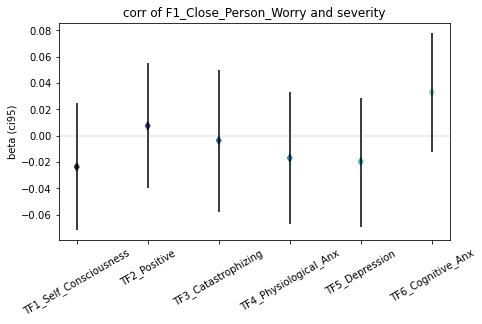

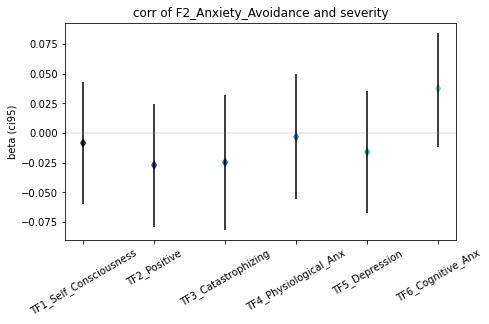

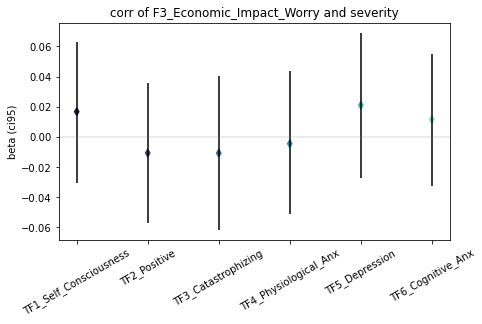

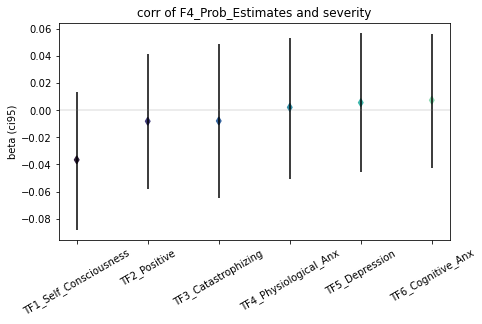

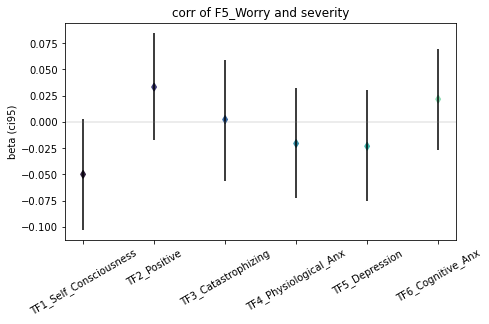

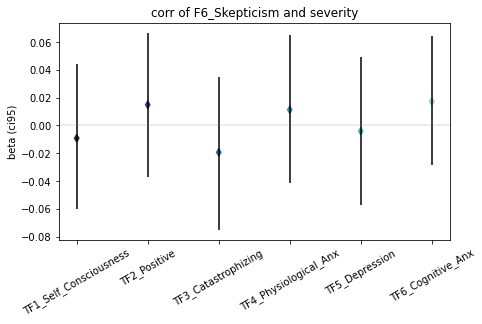

In [5]:
model_constant = "alltraits"
for f_idx, f in enumerate(factors): 
    dfl = data.loc[:,["r_"+f]+trait_factor_names].dropna()
    models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
    if "F"+str(f_idx+1)+"_"+model_constant+"_2_3000" in models.keys():
        mod = models["F"+str(f_idx+1)+"_"+model_constant+"_2_3000"]
    else:
        mod = mm.get_template()
    mod["type"] = "lmm"
    mod["lmm"]["dep_var"] = "r_"+f
    mod["lmm"]["fxeff"] = trait_factor_names 
    mod["lmm"]["rneff"] = []
    mod["est"]["nchains"] = 2
    mod["est"]["nsamples"] = 3000
    mod["name"] = "F"+str(f_idx+1)+"_"+model_constant+"_"+str(mod["est"]["nchains"])+"_"+str(mod["est"]["nsamples"])
    mod["lmm"]["eq"] = mm.generate_equation(mod["lmm"]["dep_var"], mod["lmm"]["fxeff"], mod["lmm"]["rneff"]) 
    mod["location"] = os.path.join("output", "models", "model_data", "traits_predicting_severity_correlations", mod["name"]+".dic" )
    mod["current_sys_location"] = os.path.join(root_dir, mod["location"])
    mod, res, m = mm.estimate_lmm(mod=mod, data=dfl, override=0)
    models[mod["name"]] = mod
    mm.save_model_info(models, os.path.join(root_dir, "output", "models", "model_database.json"))
    
    
    # PLOT
    tdf = pd.DataFrame()
    for tf in trait_factor_names:
        d = res.posterior[tf].stack(draws=("chain", "draw"))
        dt = pd.DataFrame(d, columns=["sample"])
        dt.loc[:,"trait_factor"] = tf
        tdf = pd.concat([tdf, dt])
    tdf

    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 4))
    # plot the CI97 posterior for the interaction with anxiety
    axs = sns.pointplot(x="trait_factor", y= "sample",
                  data=tdf, dodge=.532, join=False, palette=sns.color_palette("mako",6),
                  markers="d", scale=.75, ci=None);
    bounds = tdf.groupby("trait_factor")['sample'].quantile((0.025,0.975)).unstack().reset_index().sort_values(by="trait_factor")
    axs.vlines(bounds.trait_factor, bounds.iloc[:,1], bounds.iloc[:,2], colors='black')
    axs.axhline(0, alpha=0.2, color='gray')
    axs.set_title("corr of "+f+" and severity")
    axs.set_ylabel("beta (ci95)")
    axs.set_xlabel("")
    axs.set_xticklabels(trait_factor_names, rotation = 30)

In [6]:
df

Unnamed: 0  index        PROLIFICID           submitdate  lastpage  \
0              0      0  QtSR7Fx0WLVP2liF  2020-04-18 00:00:00      12.0   
1              1      1  cSYnOWVWsFZkmRRN  2020-04-18 00:00:00      12.0   
2              2      2  mARrf4HdnbRbkTNa  2020-04-19 00:00:00      12.0   
3              3      3  Ax1wbTIuhyw0Pq2m  2020-04-20 00:00:00      12.0   
4              4      4  UsZ8Ias7tqaxleMP  2020-04-20 00:00:00      12.0   
...          ...    ...               ...                  ...       ...   
5804        5101   5101  DTKlL6ywT10PrKbU           2020-12-17      12.0   
5805        5102   5102  fyhqLp9TbqmeocVE           2020-12-14      12.0   
5806        5103   5103  UB8TW6SUK5nkQNyp           2020-12-16      12.0   
5807        5104   5104  XMOqrYQHAEyYgwpY           2020-12-16      12.0   
5808        5105   5105  VKBlIYl70k6WYBCd           2020-12-16      12.0   

     GROUP  sr_age sr_gender sr_postcode  q6_me_inf  ...  cases7_std  \
0       BE    24.0         M       13355        0.0  ...   -0.243182   
1       BE    34.0         F          10        0.0  ...   -0.243182   
2       BE    27.0         F       12103        0.0  ...   -0.272425   
3       BE    26.0         M       10119        0.0  ...   -0.299712   
4       BE    19.0         F       10409        0.0  ...   -0.299712   
...    ...     ...       ...         ...        ...  ...         ...   
5804    UK    24.0         F     GI152JQ        0.0  ...         NaN   
5805    UK    32.0         M         WA2        0.0  ...    0.269826   
5806    UK    27.0         F     TN248PR        0.0  ...    2.784641   
5807    UK    20.0         F         LN5        0.0  ...    1.779959   
5808    UK    40.0         M        LS10        0.0  ...    0.123803   

      deaths7_std  cases7_norm  deaths7_norm  postcode        date  \
0        0.703655     0.128257      0.332232     13355         NaN   
1        0.703655     0.128257      0.332232        10         NaN   
2        0.720610     0.119747      0.336354     12103         NaN   
3        0.758825     0.111807      0.345645     10119         NaN   
4        0.758825     0.111807      0.345645     10409         NaN   
...           ...          ...           ...       ...         ...   
5804          NaN          NaN           NaN      GI15  2020-12-17   
5805     0.757255     0.331627      0.524862       WA2  2020-12-14   
5806     1.971765     0.748606      0.660377      TN24  2020-12-16   
5807     2.424255     0.747327      0.983333       LN5  2020-12-16   
5808     0.494042     0.285349      0.399682      LS10  2020-12-16   

      q6_econ_impact_me_ranged  q6_econ_impact_closep_ranged  \
0                     0.666667                      0.833333   
1                     0.666667                      1.000000   
2                     0.000000                      0.000000   
3                     1.000000                      0.833333   
4                     0.166667                      0.166667   
...                        ...                           ...   
5804                  0.500000                      0.500000   
5805                  0.666667                      0.666667   
5806                  0.666667                      0.833333   
5807                  0.166667                      0.166667   
5808                  0.666667                      0.666667   

      q6_close_person_inf_resc_ranged state_severity  
0                                 0.0       1.832232  
1                                 0.0       1.998899  
2                                 0.0       0.336354  
3                                 0.0       2.178979  
4                                 0.0       0.678979  
...                               ...            ...  
5804                              0.0            NaN  
5805                              0.0       1.858195  
5806                              0.0       2.160377  
5807                              0.0       2.316667  
5808         

### Model 0: traits + severity + traits * severity + (session|ID)
e.g.
$$
Worry \sim  Severity + TF_1 + TF_1*Severity  + TF_2 + TF_2*Severity + session + (session|subject) 
$$

In [10]:
from IPython import display
#factors_temp = ["F1_Close_Person_Worry"]
model_constant = "severity_onlysession_slope"
estimate1 = 0
if estimate1:
    for f_idx, f in enumerate(factors): 
        dfl = df.loc[:,[f, "state_severity", "PROLIFICID", "session"]+trait_factor_names].dropna()
        models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
        if "F"+str(f_idx+1)+"_"+model_constant+"_2_3000" in models.keys():
            mod = models["F"+str(f_idx+1)+"_"+model_constant+"_2_3000"]
        else:
            mod = mm.get_template()
        mod["type"] = "lmm"
        mod["lmm"]["dep_var"] = f
        mod["lmm"]["fxeff"] = ["state_severity"]+trait_factor_names+['state_severity*'+i for i in trait_factor_names]+["session"]
        mod["lmm"]["rneff"] = ["1|PROLIFICID"]
        mod["est"]["nchains"] = 2
        mod["est"]["nsamples"] = 3000
        mod["est"]["ncores"] = 2
        mod["name"] = "F"+str(f_idx+1)+"_"+model_constant+"_"+str(mod["est"]["nchains"])+"_"+str(mod["est"]["nsamples"])
        mod["lmm"]["eq"] = mm.generate_equation(mod["lmm"]["dep_var"], mod["lmm"]["fxeff"], mod["lmm"]["rneff"]) 
        mod["location"] = os.path.join("output", "models", "model_data", "traits_predicting_severity_correlations", mod["name"]+".dic" )
        mod["current_sys_location"] = os.path.join(root_dir, mod["location"])
        #mod, res, m = mm.estimate_lmm(mod=mod, data=dfl, override=1)
        models[mod["name"]] = mod
        print(mod["lmm"]["eq"])
        #mm.save_model_info(models, os.path.join(root_dir, "output", "models", "model_database.json"))
    



F1_Close_Person_Worry ~ state_severity + TF1_Self_Consciousness + TF2_Positive + TF3_Catastrophizing + TF4_Physiological_Anx + TF5_Depression + TF6_Cognitive_Anx + state_severity*TF1_Self_Consciousness + state_severity*TF2_Positive + state_severity*TF3_Catastrophizing + state_severity*TF4_Physiological_Anx + state_severity*TF5_Depression + state_severity*TF6_Cognitive_Anx + session + (1|PROLIFICID)
F2_Anxiety_Avoidance ~ state_severity + TF1_Self_Consciousness + TF2_Positive + TF3_Catastrophizing + TF4_Physiological_Anx + TF5_Depression + TF6_Cognitive_Anx + state_severity*TF1_Self_Consciousness + state_severity*TF2_Positive + state_severity*TF3_Catastrophizing + state_severity*TF4_Physiological_Anx + state_severity*TF5_Depression + state_severity*TF6_Cognitive_Anx + session + (1|PROLIFICID)
F3_Economic_Impact_Worry ~ state_severity + TF1_Self_Consciousness + TF2_Positive + TF3_Catastrophizing + TF4_Physiological_Anx + TF5_Depression + TF6_Cognitive_Anx + state_severity*TF1_Self_Consci

/data/drive/postdoc/Project4_covid/output/models/model_data/traits_predicting_severity_correlations/F1_severity_onlysession_slope_4_3000.dic
Model F1_severity_onlysession_slope_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  \
Intercept                              1.608  0.030   1.553    1.665   
state_severity                         0.175  0.009   0.158    0.193   
TF1_Self_Consciousness                -0.050  0.036  -0.119    0.016   
TF2_Positive                           0.035  0.037  -0.034    0.103   
TF3_Catastrophizing                    0.292  0.038   0.220    0.362   
TF4_Physiological_Anx                  0.070  0.035   0.002    0.135   
TF5_Depression                         0.008  0.035  -0.059    0.075   
TF6_Cognitive_Anx                     -0.010  0.034  -0.074    0.052   
state_severity:TF1_Self_Consciousness  0.009  0.012  -0.014    0.031   
state_severity:TF2_Positive           -0.014  0.011  -0.034    0.008   
state_severity:TF3_Catastrophizing    -0.023  0.012  -0.045   -0.000   
state_severity:TF4_Physiological_Anx  -0.023  0.011  -0.044   -0.003   
state_severity:TF5_Depression         -0.013  0.011  -0.034    0.008   
state_severity:TF6_Cognitive_Anx       0.027  0.011   0.008    0.048   
session                               -0.014  0.002  -0.017   -0.010   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept                                  0.000      0.0    4766.0    6313.0   
state_severity                             0.000      0.0   15953.0   10004.0   
TF1_Self_Consciousness                     0.001      0.0    4825.0    6359.0   
TF2_Positive                               0.001      0.0    4381.0    6669.0   
TF3_Catastrophizing                        0.001      0.0    5140.0    6155.0   
TF4_Physiological_Anx                      0.001      0.0    4980.0    6886.0   
TF5_Depression                             0.001      0.0    4691.0    7312.0   
TF6_Cognitive_Anx                          0.000      0.0    4811.0    6609.0   
state_severity:TF1_Self_Consciousness      0.000      0.0   17077.0    9605.0   
state_severity:TF2_Positive                0.000      0.0   18032.0    9896.0   
state_severity:TF3_Catastrophizing         0.000      0.0   19239.0    9347.0   
state_severity:TF4_Physiological_Anx       0.000      0.0   18986.0   10247.0   
state_severity:TF5_Depression              0.000      0.0   16692.0   10020.0   
state_severity:TF6_Cognitive_Anx           0.000      0.0   17750.0   10268.0   
session                                    0.000      0.0    8379.0    8879.0   

                                       r_hat  
Intercept                                1.0  
state_severity                           1.0  
TF1_Self_Consciousness                   1.0  
TF2_Positive                             1.0  
TF3_Catastrophizing                      1.0  
TF4_Physiological_Anx                    1.0  
TF5_Depression                           1.0  
TF6_Cognitive_Anx                        1.0  
state_severity:TF1_Self_Consciousness    1.0  
state_severity:TF2_Positive              1.0  
state_severity:TF3_Catastrophizing       1.0  
state_severity:TF4_Physiological_Anx     1.0  
state_severity:TF5_Depression            1.0  
state_severity:TF6_Cognitive_Anx         1.0  
session                                  1.0

/data/drive/postdoc/Project4_covid/output/models/model_data/traits_predicting_severity_correlations/F2_severity_onlysession_slope_4_3000.dic
Model F2_severity_onlysession_slope_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  \
Intercept                              3.899  0.071   3.769    4.030   
state_severity                         0.236  0.015   0.209    0.264   
TF1_Self_Consciousness                -0.148  0.087  -0.313    0.013   
TF2_Positive                           0.206  0.086   0.044    0.364   
TF3_Catastrophizing                    0.524  0.090   0.357    0.691   
TF4_Physiological_Anx                 -0.005  0.082  -0.161    0.147   
TF5_Depression                         0.006  0.085  -0.148    0.170   
TF6_Cognitive_Anx                     -0.009  0.079  -0.158    0.139   
state_severity:TF1_Self_Consciousness  0.027  0.019  -0.009    0.062   
state_severity:TF2_Positive           -0.031  0.017  -0.064    0.001   
state_severity:TF3_Catastrophizing    -0.022  0.019  -0.057    0.015   
state_severity:TF4_Physiological_Anx  -0.014  0.017  -0.045    0.019   
state_severity:TF5_Depression         -0.051  0.018  -0.085   -0.018   
state_severity:TF6_Cognitive_Anx       0.056  0.017   0.025    0.087   
session                               -0.035  0.004  -0.042   -0.028   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept                                  0.002    0.001    1446.0    2863.0   
state_severity                             0.000    0.000   14703.0    9452.0   
TF1_Self_Consciousness                     0.002    0.002    1398.0    2857.0   
TF2_Positive                               0.002    0.002    1334.0    2171.0   
TF3_Catastrophizing                        0.002    0.002    1382.0    2711.0   
TF4_Physiological_Anx                      0.002    0.001    1647.0    2866.0   
TF5_Depression                             0.002    0.002    1465.0    2933.0   
TF6_Cognitive_Anx                          0.002    0.001    1710.0    3525.0   
state_severity:TF1_Self_Consciousness      0.000    0.000   15441.0   10023.0   
state_severity:TF2_Positive                0.000    0.000   13841.0   10541.0   
state_severity:TF3_Catastrophizing         0.000    0.000   14066.0    9798.0   
state_severity:TF4_Physiological_Anx       0.000    0.000   15014.0    9742.0   
state_severity:TF5_Depression              0.000    0.000   13995.0    9826.0   
state_severity:TF6_Cognitive_Anx           0.000    0.000   13701.0    8795.0   
session                                    0.000    0.000    2771.0    5713.0   

                                       r_hat  
Intercept                               1.00  
state_severity                          1.00  
TF1_Self_Consciousness                  1.00  
TF2_Positive                            1.00  
TF3_Catastrophizing                     1.00  
TF4_Physiological_Anx                   1.00  
TF5_Depression                          1.00  
TF6_Cognitive_Anx                       1.01  
state_severity:TF1_Self_Consciousness   1.00  
state_severity:TF2_Positive             1.00  
state_severity:TF3_Catastrophizing      1.00  
state_severity:TF4_Physiological_Anx    1.00  
state_severity:TF5_Depression           1.00  
state_severity:TF6_Cognitive_Anx        1.00  
session                                 1.00

/data/drive/postdoc/Project4_covid/output/models/model_data/traits_predicting_severity_correlations/F3_severity_onlysession_slope_4_3000.dic
Model F3_severity_onlysession_slope_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  \
Intercept                              1.151  0.028   1.099    1.205   
state_severity                         0.157  0.007   0.144    0.170   
TF1_Self_Consciousness                 0.007  0.035  -0.055    0.076   
TF2_Positive                           0.050  0.036  -0.018    0.120   
TF3_Catastrophizing                    0.158  0.037   0.086    0.227   
TF4_Physiological_Anx                 -0.007  0.035  -0.075    0.056   
TF5_Depression                         0.043  0.035  -0.023    0.109   
TF6_Cognitive_Anx                     -0.031  0.033  -0.093    0.030   
state_severity:TF1_Self_Consciousness  0.001  0.009  -0.016    0.017   
state_severity:TF2_Positive           -0.010  0.008  -0.025    0.005   
state_severity:TF3_Catastrophizing    -0.022  0.009  -0.039   -0.006   
state_severity:TF4_Physiological_Anx   0.011  0.008  -0.004    0.026   
state_severity:TF5_Depression          0.001  0.009  -0.015    0.017   
state_severity:TF6_Cognitive_Anx       0.039  0.008   0.024    0.053   
session                               -0.010  0.001  -0.012   -0.007   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept                                  0.001    0.000    2376.0    4700.0   
state_severity                             0.000    0.000   20448.0    9657.0   
TF1_Self_Consciousness                     0.001    0.000    2572.0    4726.0   
TF2_Positive                               0.001    0.001    2276.0    4000.0   
TF3_Catastrophizing                        0.001    0.001    2558.0    4826.0   
TF4_Physiological_Anx                      0.001    0.001    2288.0    4283.0   
TF5_Depression                             0.001    0.001    2399.0    4549.0   
TF6_Cognitive_Anx                          0.001    0.000    2639.0    4533.0   
state_severity:TF1_Self_Consciousness      0.000    0.000   18624.0    9618.0   
state_severity:TF2_Positive                0.000    0.000   17140.0    9459.0   
state_severity:TF3_Catastrophizing         0.000    0.000   18205.0   10431.0   
state_severity:TF4_Physiological_Anx       0.000    0.000   20046.0    8871.0   
state_severity:TF5_Depression              0.000    0.000   17606.0   10220.0   
state_severity:TF6_Cognitive_Anx           0.000    0.000   20240.0   10627.0   
session                                    0.000    0.000    6893.0    8634.0   

                                       r_hat  
Intercept                                1.0  
state_severity                           1.0  
TF1_Self_Consciousness                   1.0  
TF2_Positive                             1.0  
TF3_Catastrophizing                      1.0  
TF4_Physiological_Anx                    1.0  
TF5_Depression                           1.0  
TF6_Cognitive_Anx                        1.0  
state_severity:TF1_Self_Consciousness    1.0  
state_severity:TF2_Positive              1.0  
state_severity:TF3_Catastrophizing       1.0  
state_severity:TF4_Physiological_Anx     1.0  
state_severity:TF5_Depression            1.0  
state_severity:TF6_Cognitive_Anx         1.0  
session                                  1.0

/data/drive/postdoc/Project4_covid/output/models/model_data/traits_predicting_severity_correlations/F4_severity_onlysession_slope_4_3000.dic
Model F4_severity_onlysession_slope_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  \
Intercept                              1.122  0.037   1.053    1.191   
state_severity                         0.168  0.008   0.153    0.184   
TF1_Self_Consciousness                 0.024  0.045  -0.061    0.108   
TF2_Positive                          -0.116  0.045  -0.198   -0.029   
TF3_Catastrophizing                    0.163  0.047   0.079    0.252   
TF4_Physiological_Anx                  0.096  0.044   0.011    0.177   
TF5_Depression                         0.038  0.044  -0.045    0.121   
TF6_Cognitive_Anx                     -0.106  0.042  -0.184   -0.030   
state_severity:TF1_Self_Consciousness  0.006  0.010  -0.012    0.026   
state_severity:TF2_Positive            0.008  0.010  -0.010    0.026   
state_severity:TF3_Catastrophizing    -0.001  0.010  -0.020    0.019   
state_severity:TF4_Physiological_Anx  -0.018  0.009  -0.036   -0.000   
state_severity:TF5_Depression         -0.018  0.010  -0.037   -0.000   
state_severity:TF6_Cognitive_Anx       0.025  0.009   0.008    0.042   
session                               -0.009  0.002  -0.012   -0.006   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept                                  0.001    0.001    1470.0    2496.0   
state_severity                             0.000    0.000   18038.0   10474.0   
TF1_Self_Consciousness                     0.001    0.001    1912.0    3601.0   
TF2_Positive                               0.001    0.001    1846.0    3241.0   
TF3_Catastrophizing                        0.001    0.001    2206.0    3808.0   
TF4_Physiological_Anx                      0.001    0.001    1917.0    3601.0   
TF5_Depression                             0.001    0.001    1997.0    3738.0   
TF6_Cognitive_Anx                          0.001    0.001    2017.0    3495.0   
state_severity:TF1_Self_Consciousness      0.000    0.000   16893.0    9975.0   
state_severity:TF2_Positive                0.000    0.000   17598.0   10665.0   
state_severity:TF3_Catastrophizing         0.000    0.000   16740.0    9951.0   
state_severity:TF4_Physiological_Anx       0.000    0.000   16878.0    9564.0   
state_severity:TF5_Depression              0.000    0.000   16604.0   10215.0   
state_severity:TF6_Cognitive_Anx           0.000    0.000   18661.0    9902.0   
session                                    0.000    0.000    4606.0    7082.0   

                                       r_hat  
Intercept                                1.0  
state_severity                           1.0  
TF1_Self_Consciousness                   1.0  
TF2_Positive                             1.0  
TF3_Catastrophizing                      1.0  
TF4_Physiological_Anx                    1.0  
TF5_Depression                           1.0  
TF6_Cognitive_Anx                        1.0  
state_severity:TF1_Self_Consciousness    1.0  
state_severity:TF2_Positive              1.0  
state_severity:TF3_Catastrophizing       1.0  
state_severity:TF4_Physiological_Anx     1.0  
state_severity:TF5_Depression            1.0  
state_severity:TF6_Cognitive_Anx         1.0  
session                                  1.0

/data/drive/postdoc/Project4_covid/output/models/model_data/traits_predicting_severity_correlations/F5_severity_onlysession_slope_4_3000.dic
Model F5_severity_onlysession_slope_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  \
Intercept                              2.231  0.052   2.131    2.326   
state_severity                         0.186  0.012   0.164    0.209   
TF1_Self_Consciousness                -0.146  0.065  -0.276   -0.032   
TF2_Positive                           0.255  0.065   0.134    0.379   
TF3_Catastrophizing                    0.566  0.069   0.430    0.690   
TF4_Physiological_Anx                  0.070  0.063  -0.047    0.188   
TF5_Depression                         0.009  0.063  -0.106    0.132   
TF6_Cognitive_Anx                     -0.128  0.061  -0.245   -0.016   
state_severity:TF1_Self_Consciousness -0.014  0.015  -0.041    0.014   
state_severity:TF2_Positive            0.032  0.014   0.006    0.058   
state_severity:TF3_Catastrophizing    -0.004  0.015  -0.033    0.025   
state_severity:TF4_Physiological_Anx  -0.024  0.014  -0.051    0.001   
state_severity:TF5_Depression         -0.019  0.014  -0.045    0.009   
state_severity:TF6_Cognitive_Anx       0.043  0.013   0.017    0.067   
session                               -0.018  0.002  -0.022   -0.013   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept                                  0.001    0.001    1560.0    3165.0   
state_severity                             0.000    0.000   17756.0    9001.0   
TF1_Self_Consciousness                     0.001    0.001    1981.0    3687.0   
TF2_Positive                               0.002    0.001    1682.0    3130.0   
TF3_Catastrophizing                        0.002    0.001    1890.0    3553.0   
TF4_Physiological_Anx                      0.001    0.001    1947.0    3661.0   
TF5_Depression                             0.001    0.001    1999.0    3552.0   
TF6_Cognitive_Anx                          0.001    0.001    1822.0    3301.0   
state_severity:TF1_Self_Consciousness      0.000    0.000   16207.0   10423.0   
state_severity:TF2_Positive                0.000    0.000   15717.0    9818.0   
state_severity:TF3_Catastrophizing         0.000    0.000   16046.0    9014.0   
state_severity:TF4_Physiological_Anx       0.000    0.000   18361.0   10449.0   
state_severity:TF5_Depression              0.000    0.000   15634.0   10044.0   
state_severity:TF6_Cognitive_Anx           0.000    0.000   19003.0    9624.0   
session                                    0.000    0.000    5397.0    6463.0   

                                       r_hat  
Intercept                                1.0  
state_severity                           1.0  
TF1_Self_Consciousness                   1.0  
TF2_Positive                             1.0  
TF3_Catastrophizing                      1.0  
TF4_Physiological_Anx                    1.0  
TF5_Depression                           1.0  
TF6_Cognitive_Anx                        1.0  
state_severity:TF1_Self_Consciousness    1.0  
state_severity:TF2_Positive              1.0  
state_severity:TF3_Catastrophizing       1.0  
state_severity:TF4_Physiological_Anx     1.0  
state_severity:TF5_Depression            1.0  
state_severity:TF6_Cognitive_Anx         1.0  
session                                  1.0

/data/drive/postdoc/Project4_covid/output/models/model_data/traits_predicting_severity_correlations/F6_severity_onlysession_slope_4_3000.dic
Model F6_severity_onlysession_slope_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  \
Intercept                             -0.030  0.029  -0.084    0.023   
state_severity                        -0.018  0.006  -0.029   -0.007   
TF1_Self_Consciousness                 0.019  0.035  -0.044    0.090   
TF2_Positive                          -0.014  0.035  -0.080    0.052   
TF3_Catastrophizing                   -0.151  0.037  -0.222   -0.081   
TF4_Physiological_Anx                 -0.003  0.035  -0.072    0.059   
TF5_Depression                         0.054  0.035  -0.011    0.119   
TF6_Cognitive_Anx                     -0.003  0.034  -0.067    0.060   
state_severity:TF1_Self_Consciousness  0.002  0.007  -0.012    0.016   
state_severity:TF2_Positive            0.010  0.007  -0.003    0.024   
state_severity:TF3_Catastrophizing     0.005  0.008  -0.009    0.020   
state_severity:TF4_Physiological_Anx  -0.011  0.007  -0.024    0.002   
state_severity:TF5_Depression          0.008  0.007  -0.007    0.021   
state_severity:TF6_Cognitive_Anx      -0.004  0.007  -0.017    0.008   
session                               -0.003  0.002  -0.006   -0.001   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept                                  0.001    0.001    1090.0    2610.0   
state_severity                             0.000    0.000   15283.0   10111.0   
TF1_Self_Consciousness                     0.001    0.001    1453.0    2604.0   
TF2_Positive                               0.001    0.001    1381.0    2657.0   
TF3_Catastrophizing                        0.001    0.001    1321.0    2830.0   
TF4_Physiological_Anx                      0.001    0.001    1500.0    2998.0   
TF5_Depression                             0.001    0.001    1618.0    3085.0   
TF6_Cognitive_Anx                          0.001    0.001    1109.0    2307.0   
state_severity:TF1_Self_Consciousness      0.000    0.000   12685.0    8810.0   
state_severity:TF2_Positive                0.000    0.000   12212.0   10139.0   
state_severity:TF3_Catastrophizing         0.000    0.000   14132.0   10153.0   
state_severity:TF4_Physiological_Anx       0.000    0.000   15814.0   10290.0   
state_severity:TF5_Depression              0.000    0.000   14597.0    9803.0   
state_severity:TF6_Cognitive_Anx           0.000    0.000   16158.0    9770.0   
session                                    0.000    0.000    2687.0    4487.0   

                                       r_hat  
Intercept                                1.0  
state_severity                           1.0  
TF1_Self_Consciousness                   1.0  
TF2_Positive                             1.0  
TF3_Catastrophizing                      1.0  
TF4_Physiological_Anx                    1.0  
TF5_Depression                           1.0  
TF6_Cognitive_Anx                        1.0  
state_severity:TF1_Self_Consciousness    1.0  
state_severity:TF2_Positive              1.0  
state_severity:TF3_Catastrophizing       1.0  
state_severity:TF4_Physiological_Anx     1.0  
state_severity:TF5_Depression            1.0  
state_severity:TF6_Cognitive_Anx         1.0  
session                                  1.0

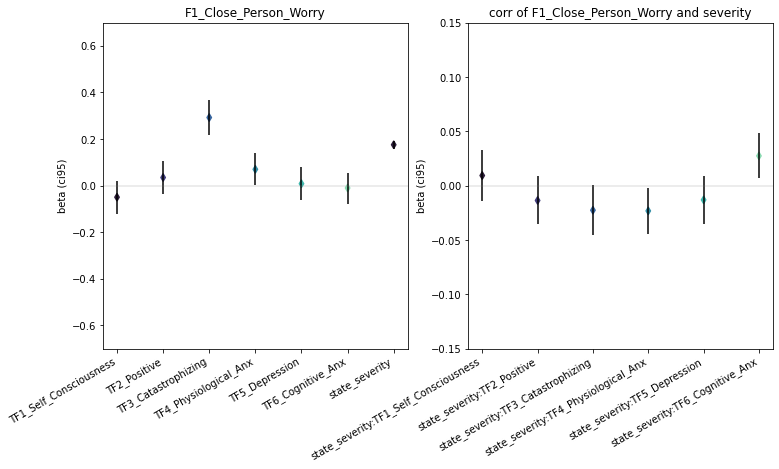

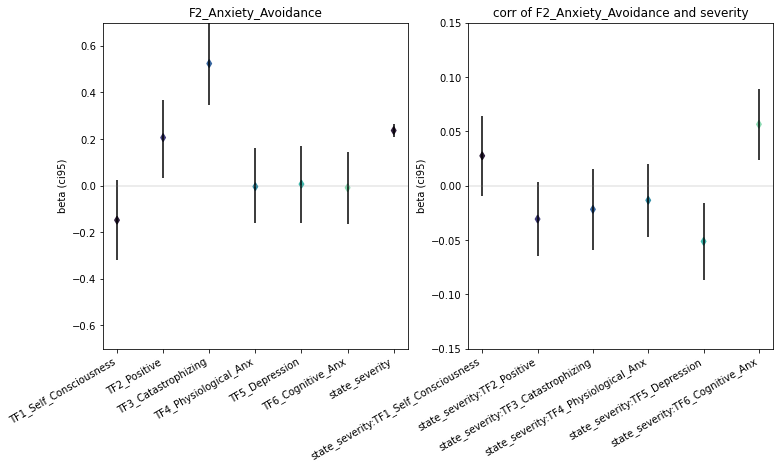

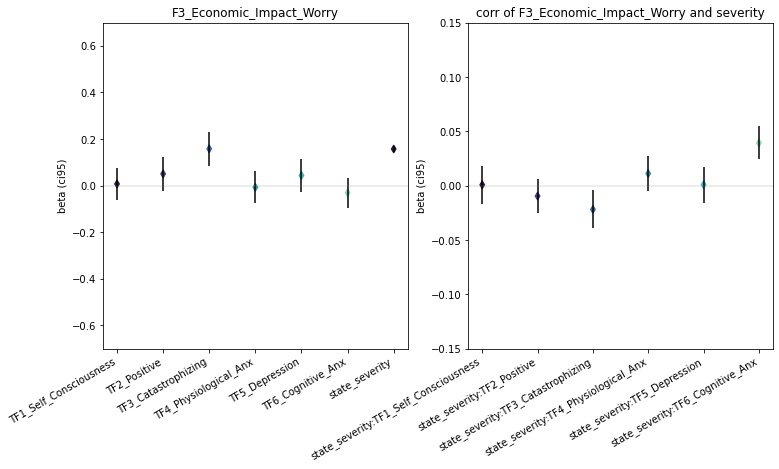

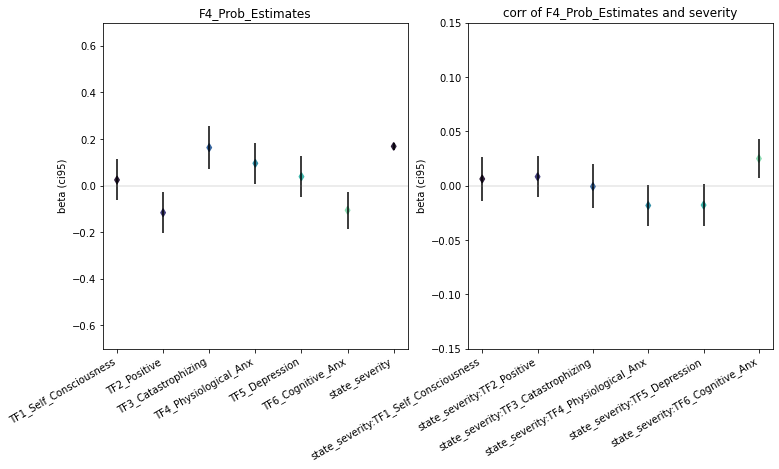

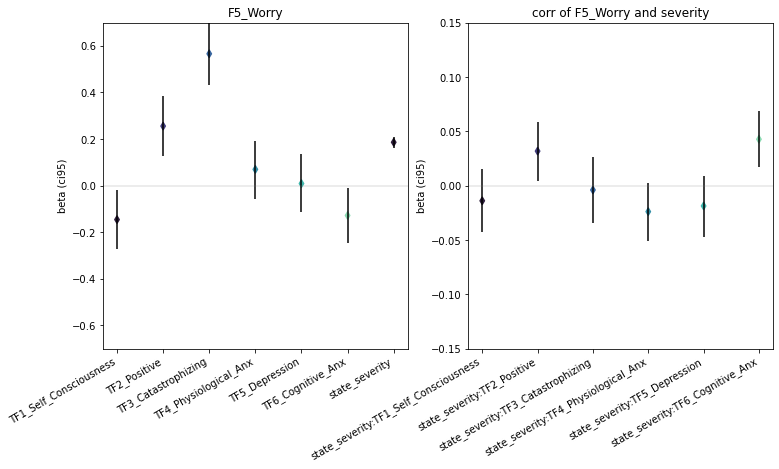

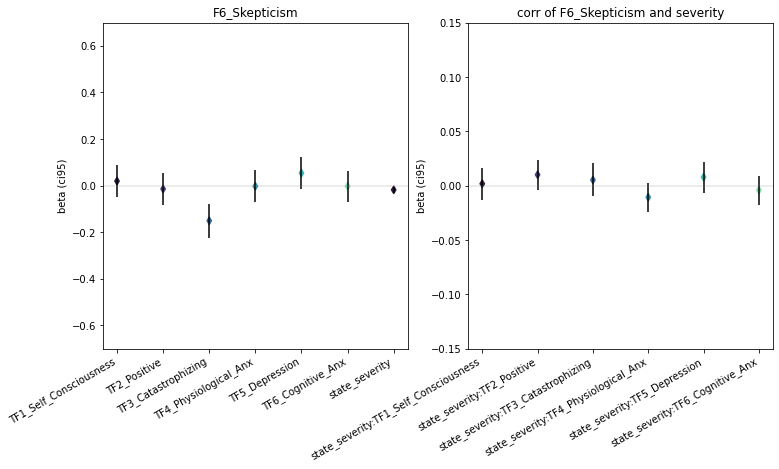

In [18]:
model_constant = "severity_onlysession_slope"
ylims = [[-0.7,0.7], [-0.15, 0.15], [-0.02, 0.02]]
folder = "traits_predicting_severity_correlations"
for f_idx, f in enumerate(factors): 
    models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
    mod = models["F"+str(f_idx+1)+"_"+model_constant+"_4_3000"]
    # assumes that models have been estimated
    mod["current_sys_location"] = os.path.join(root_dir, mod["location"])
    print(mod["current_sys_location"])
    mod, res,m  = mm.estimate_lmm(mod, [], override=0)
    # add diagnostics
    #az.plot_trace(res)
    display.display(az.summary(res).head(15))

    # PLOT
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    for gr_idx, beta_group in enumerate([trait_factor_names+['state_severity'],
                                        ['state_severity:'+i for i in trait_factor_names]]):
        tdf = pd.DataFrame()
        for tf in beta_group:
            d = res.posterior[tf].stack(draws=("chain", "draw"))
            dt = pd.DataFrame(d, columns=["sample"])
            dt.loc[:,"trait_factor"] = tf
            tdf = pd.concat([tdf, dt])
        tdf
        axs[gr_idx] = sns.pointplot(x="trait_factor", y= "sample",
                      data=tdf, dodge=.532, join=False, palette=sns.color_palette("mako",6),
                      markers="d", scale=.75, ci=None, ax =axs[gr_idx]);
        bounds = tdf.groupby("trait_factor")['sample'].quantile((0.025,0.975)).unstack().reset_index().sort_values(by="trait_factor")
        axs[gr_idx].vlines(bounds.trait_factor, bounds.iloc[:,1], bounds.iloc[:,2], colors='black')
        axs[gr_idx].axhline(0, alpha=0.2, color='gray')
        if gr_idx == 0:
            axs[gr_idx].set_title(f)
        elif gr_idx == 1:
            axs[gr_idx].set_title("corr of "+f+" and severity")
        axs[gr_idx].set_ylabel("beta (ci95)")
        axs[gr_idx].set_xlabel("")
        axs[gr_idx].set_xticklabels(beta_group, rotation = 30, ha="right")
        axs[gr_idx].set_ylim(ylims[gr_idx])

### Model 1: traits + severity + traits * severity + (session|ID)
e.g.
$$
Worry \sim  Severity + TF_1 + TF_1*Severity  + TF_2 + TF_2*Severity + (session|subject) 
$$

I also fitted this in R and the results are nearly identical

In [7]:
trait_factor_names+['state_severity']
# include state severity in the model !
#["state_severity"]+trait_factor_names+['state_severity*'+i for i in trait_factor_names]
df.loc[:,trait_factor_names+['state_severity']].describe().T


count      mean       std       min       25%  \
TF1_Self_Consciousness  5809.0  0.007623  0.979763 -2.244184 -0.690306   
TF2_Positive            5809.0  0.008274  0.994306 -2.288488 -0.760967   
TF3_Catastrophizing     5809.0  0.001913  0.925806 -2.242873 -0.667790   
TF4_Physiological_Anx   5809.0 -0.004805  0.929712 -1.949699 -0.674587   
TF5_Depression          5809.0  0.002158  0.935329 -2.125529 -0.693618   
TF6_Cognitive_Anx       5809.0  0.000195  0.975563 -2.021540 -0.683750   
state_severity          5012.0  1.075778  0.829016  0.000000  0.339680   

                             50%       75%       max  
TF1_Self_Consciousness -0.227905  0.536015  3.919539  
TF2_Positive           -0.065850  0.732348  2.159791  
TF3_Catastrophizing    -0.107990  0.666218  2.629625  
TF4_Physiological_Anx  -0.235141  0.596735  3.533412  
TF5_Depression         -0.093618  0.491560  3.462862  
TF6_Cognitive_Anx      -0.024807  0.673904  2.598208  
state_severity          1.002339  1.666667  4.571429

In [8]:
from IPython import display
#factors_temp = ["F1_Close_Person_Worry"]
model_constant = "severity_noslope_ND"
estimate1 = 0
if estimate1:
    for f_idx, f in enumerate(factors): 
        dfl = df.loc[:,[f, "state_severity", "PROLIFICID", "session"]+trait_factor_names].dropna()
        models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
        if "F"+str(f_idx+1)+"_"+model_constant+"_2_3000" in models.keys():
            mod = models["F"+str(f_idx+1)+"_"+model_constant+"_2_3000"]
        else:
            mod = mm.get_template()
        mod["type"] = "lmm"
        mod["lmm"]["dep_var"] = f
        mod["lmm"]["fxeff"] = ["state_severity"]+trait_factor_names+['state_severity*'+i for i in trait_factor_names]
        mod["lmm"]["rneff"] = ["session|PROLIFICID"]
        mod["est"]["nchains"] = 2
        mod["est"]["nsamples"] = 3000
        mod["est"]["ncores"] = 2
        mod["name"] = "F"+str(f_idx+1)+"_"+model_constant+"_"+str(mod["est"]["nchains"])+"_"+str(mod["est"]["nsamples"])
        mod["lmm"]["eq"] = mm.generate_equation(mod["lmm"]["dep_var"], mod["lmm"]["fxeff"], mod["lmm"]["rneff"]) 
        mod["location"] = os.path.join("output", "models", "model_data", "traits_predicting_severity_correlations", mod["name"]+".dic" )
        mod["current_sys_location"] = os.path.join(root_dir, mod["location"])
        mod, res, m = mm.estimate_lmm(mod=mod, data=dfl, override=0)
        models[mod["name"]] = mod
        print(mod["lmm"]["eq"])
        mm.save_model_info(models, os.path.join(root_dir, "output", "models", "model_database.json"))
    



Model F1_severity_noslope_ND_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  \
Intercept                              1.586  0.030   1.528    1.641   
state_severity                         0.179  0.009   0.162    0.197   
TF1_Self_Consciousness                -0.050  0.037  -0.119    0.020   
TF2_Positive                           0.038  0.037  -0.031    0.108   
TF3_Catastrophizing                    0.290  0.039   0.216    0.362   
TF4_Physiological_Anx                  0.069  0.036   0.000    0.136   
TF5_Depression                         0.008  0.036  -0.061    0.074   
TF6_Cognitive_Anx                     -0.011  0.035  -0.076    0.054   
state_severity:TF1_Self_Consciousness  0.008  0.012  -0.015    0.029   
state_severity:TF2_Positive           -0.014  0.011  -0.036    0.006   
state_severity:TF3_Catastrophizing    -0.021  0.012  -0.044    0.002   
state_severity:TF4_Physiological_Anx  -0.024  0.011  -0.045   -0.003   
state_severity:TF5_Depression         -0.015  0.011  -0.035    0.007   
state_severity:TF6_Cognitive_Anx       0.030  0.011   0.011    0.050   
1|PROLIFICID_sigma                     0.462  0.022   0.423    0.506   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept                                  0.000      0.0    4685.0    6404.0   
state_severity                             0.000      0.0   17351.0   10129.0   
TF1_Self_Consciousness                     0.001      0.0    5086.0    6720.0   
TF2_Positive                               0.001      0.0    4723.0    7003.0   
TF3_Catastrophizing                        0.001      0.0    4597.0    6805.0   
TF4_Physiological_Anx                      0.001      0.0    4530.0    6920.0   
TF5_Depression                             0.000      0.0    5643.0    7304.0   
TF6_Cognitive_Anx                          0.000      0.0    4916.0    6867.0   
state_severity:TF1_Self_Consciousness      0.000      0.0   18105.0    9165.0   
state_severity:TF2_Positive                0.000      0.0   18104.0    9926.0   
state_severity:TF3_Catastrophizing         0.000      0.0   19964.0    9510.0   
state_severity:TF4_Physiological_Anx       0.000      0.0   18435.0    9582.0   
state_severity:TF5_Depression              0.000      0.0   18548.0    9455.0   
state_severity:TF6_Cognitive_Anx           0.000      0.0   19648.0    9836.0   
1|PROLIFICID_sigma                         0.000      0.0    5724.0    6962.0   

                                       r_hat  
Intercept                                1.0  
state_severity                           1.0  
TF1_Self_Consciousness                   1.0  
TF2_Positive                             1.0  
TF3_Catastrophizing                      1.0  
TF4_Physiological_Anx                    1.0  
TF5_Depression                           1.0  
TF6_Cognitive_Anx                        1.0  
state_severity:TF1_Self_Consciousness    1.0  
state_severity:TF2_Positive              1.0  
state_severity:TF3_Catastrophizing       1.0  
state_severity:TF4_Physiological_Anx     1.0  
state_severity:TF5_Depression            1.0  
state_severity:TF6_Cognitive_Anx         1.0  
1|PROLIFICID_sigma                       1.0

Model F2_severity_noslope_ND_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  \
Intercept                              3.868  0.070   3.737    3.998   
state_severity                         0.241  0.015   0.214    0.269   
TF1_Self_Consciousness                -0.140  0.087  -0.304    0.019   
TF2_Positive                           0.206  0.087   0.046    0.371   
TF3_Catastrophizing                    0.519  0.090   0.345    0.684   
TF4_Physiological_Anx                 -0.005  0.086  -0.163    0.158   
TF5_Depression                        -0.002  0.086  -0.159    0.161   
TF6_Cognitive_Anx                     -0.007  0.079  -0.158    0.139   
state_severity:TF1_Self_Consciousness  0.024  0.019  -0.010    0.061   
state_severity:TF2_Positive           -0.031  0.018  -0.063    0.004   
state_severity:TF3_Catastrophizing    -0.019  0.019  -0.057    0.016   
state_severity:TF4_Physiological_Anx  -0.013  0.017  -0.046    0.020   
state_severity:TF5_Depression         -0.054  0.018  -0.089   -0.021   
state_severity:TF6_Cognitive_Anx       0.058  0.017   0.027    0.090   
1|PROLIFICID_sigma                     1.123  0.052   1.024    1.217   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept                                  0.002    0.002    1104.0    1990.0   
state_severity                             0.000    0.000   14499.0   10283.0   
TF1_Self_Consciousness                     0.002    0.002    1375.0    2988.0   
TF2_Positive                               0.002    0.002    1292.0    2846.0   
TF3_Catastrophizing                        0.002    0.002    1663.0    3073.0   
TF4_Physiological_Anx                      0.002    0.001    1628.0    3256.0   
TF5_Depression                             0.002    0.002    1498.0    2827.0   
TF6_Cognitive_Anx                          0.002    0.001    1495.0    3077.0   
state_severity:TF1_Self_Consciousness      0.000    0.000   14154.0   10014.0   
state_severity:TF2_Positive                0.000    0.000   14899.0    9986.0   
state_severity:TF3_Catastrophizing         0.000    0.000   14228.0    9218.0   
state_severity:TF4_Physiological_Anx       0.000    0.000   14489.0    9979.0   
state_severity:TF5_Depression              0.000    0.000   13601.0    9485.0   
state_severity:TF6_Cognitive_Anx           0.000    0.000   16398.0    9718.0   
1|PROLIFICID_sigma                         0.001    0.001    2385.0    4459.0   

                                       r_hat  
Intercept                               1.01  
state_severity                          1.00  
TF1_Self_Consciousness                  1.00  
TF2_Positive                            1.00  
TF3_Catastrophizing                     1.00  
TF4_Physiological_Anx                   1.00  
TF5_Depression                          1.00  
TF6_Cognitive_Anx                       1.01  
state_severity:TF1_Self_Consciousness   1.00  
state_severity:TF2_Positive             1.00  
state_severity:TF3_Catastrophizing      1.00  
state_severity:TF4_Physiological_Anx    1.00  
state_severity:TF5_Depression           1.00  
state_severity:TF6_Cognitive_Anx        1.00  
1|PROLIFICID_sigma                      1.00

Model F3_severity_noslope_ND_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  \
Intercept                              1.135  0.029   1.078    1.188   
state_severity                         0.158  0.007   0.144    0.171   
TF1_Self_Consciousness                 0.007  0.036  -0.056    0.077   
TF2_Positive                           0.050  0.036  -0.021    0.115   
TF3_Catastrophizing                    0.159  0.038   0.088    0.229   
TF4_Physiological_Anx                 -0.009  0.036  -0.078    0.055   
TF5_Depression                         0.043  0.035  -0.022    0.109   
TF6_Cognitive_Anx                     -0.030  0.033  -0.094    0.030   
state_severity:TF1_Self_Consciousness -0.001  0.009  -0.018    0.015   
state_severity:TF2_Positive           -0.008  0.008  -0.023    0.008   
state_severity:TF3_Catastrophizing    -0.021  0.009  -0.039   -0.004   
state_severity:TF4_Physiological_Anx   0.011  0.008  -0.005    0.026   
state_severity:TF5_Depression         -0.001  0.009  -0.017    0.015   
state_severity:TF6_Cognitive_Anx       0.041  0.008   0.027    0.056   
1|PROLIFICID_sigma                     0.460  0.022   0.417    0.498   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept                                  0.001    0.000    2188.0    3959.0   
state_severity                             0.000    0.000   19445.0   10457.0   
TF1_Self_Consciousness                     0.001    0.001    2466.0    4268.0   
TF2_Positive                               0.001    0.001    1808.0    3139.0   
TF3_Catastrophizing                        0.001    0.001    2393.0    4595.0   
TF4_Physiological_Anx                      0.001    0.001    2239.0    4052.0   
TF5_Depression                             0.001    0.001    2300.0    4174.0   
TF6_Cognitive_Anx                          0.001    0.000    2413.0    4075.0   
state_severity:TF1_Self_Consciousness      0.000    0.000   18593.0    9757.0   
state_severity:TF2_Positive                0.000    0.000   17493.0    9855.0   
state_severity:TF3_Catastrophizing         0.000    0.000   19587.0    9863.0   
state_severity:TF4_Physiological_Anx       0.000    0.000   19253.0    9767.0   
state_severity:TF5_Depression              0.000    0.000   17177.0    9883.0   
state_severity:TF6_Cognitive_Anx           0.000    0.000   19845.0    9431.0   
1|PROLIFICID_sigma                         0.000    0.000    3206.0    5792.0   

                                       r_hat  
Intercept                                1.0  
state_severity                           1.0  
TF1_Self_Consciousness                   1.0  
TF2_Positive                             1.0  
TF3_Catastrophizing                      1.0  
TF4_Physiological_Anx                    1.0  
TF5_Depression                           1.0  
TF6_Cognitive_Anx                        1.0  
state_severity:TF1_Self_Consciousness    1.0  
state_severity:TF2_Positive              1.0  
state_severity:TF3_Catastrophizing       1.0  
state_severity:TF4_Physiological_Anx     1.0  
state_severity:TF5_Depression            1.0  
state_severity:TF6_Cognitive_Anx         1.0  
1|PROLIFICID_sigma                       1.0

Model F4_severity_noslope_ND_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  \
Intercept                              1.109  0.037   1.040    1.178   
state_severity                         0.170  0.008   0.155    0.186   
TF1_Self_Consciousness                 0.024  0.045  -0.062    0.109   
TF2_Positive                          -0.118  0.044  -0.201   -0.036   
TF3_Catastrophizing                    0.161  0.047   0.072    0.248   
TF4_Physiological_Anx                  0.095  0.044   0.012    0.178   
TF5_Depression                         0.039  0.044  -0.046    0.117   
TF6_Cognitive_Anx                     -0.104  0.041  -0.181   -0.026   
state_severity:TF1_Self_Consciousness  0.005  0.010  -0.015    0.024   
state_severity:TF2_Positive            0.009  0.010  -0.010    0.026   
state_severity:TF3_Catastrophizing    -0.000  0.011  -0.020    0.019   
state_severity:TF4_Physiological_Anx  -0.019  0.009  -0.036   -0.001   
state_severity:TF5_Depression         -0.019  0.010  -0.037    0.001   
state_severity:TF6_Cognitive_Anx       0.026  0.009   0.009    0.043   
1|PROLIFICID_sigma                     0.576  0.026   0.526    0.625   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept                                  0.001    0.001    1668.0    3020.0   
state_severity                             0.000    0.000   18853.0   10363.0   
TF1_Self_Consciousness                     0.001    0.001    1879.0    2891.0   
TF2_Positive                               0.001    0.001    1942.0    3606.0   
TF3_Catastrophizing                        0.001    0.001    2201.0    3511.0   
TF4_Physiological_Anx                      0.001    0.001    1796.0    3386.0   
TF5_Depression                             0.001    0.001    2220.0    4213.0   
TF6_Cognitive_Anx                          0.001    0.001    1896.0    3492.0   
state_severity:TF1_Self_Consciousness      0.000    0.000   16687.0   10360.0   
state_severity:TF2_Positive                0.000    0.000   16597.0   10275.0   
state_severity:TF3_Catastrophizing         0.000    0.000   17397.0    9827.0   
state_severity:TF4_Physiological_Anx       0.000    0.000   18698.0   10129.0   
state_severity:TF5_Depression              0.000    0.000   18166.0   10466.0   
state_severity:TF6_Cognitive_Anx           0.000    0.000   18249.0   10431.0   
1|PROLIFICID_sigma                         0.000    0.000    2906.0    4877.0   

                                       r_hat  
Intercept                                1.0  
state_severity                           1.0  
TF1_Self_Consciousness                   1.0  
TF2_Positive                             1.0  
TF3_Catastrophizing                      1.0  
TF4_Physiological_Anx                    1.0  
TF5_Depression                           1.0  
TF6_Cognitive_Anx                        1.0  
state_severity:TF1_Self_Consciousness    1.0  
state_severity:TF2_Positive              1.0  
state_severity:TF3_Catastrophizing       1.0  
state_severity:TF4_Physiological_Anx     1.0  
state_severity:TF5_Depression            1.0  
state_severity:TF6_Cognitive_Anx         1.0  
1|PROLIFICID_sigma                       1.0

Model F5_severity_noslope_ND_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  \
Intercept                              2.206  0.054   2.100    2.301   
state_severity                         0.189  0.012   0.167    0.211   
TF1_Self_Consciousness                -0.148  0.066  -0.271   -0.022   
TF2_Positive                           0.259  0.065   0.129    0.375   
TF3_Catastrophizing                    0.562  0.068   0.439    0.696   
TF4_Physiological_Anx                  0.070  0.063  -0.048    0.189   
TF5_Depression                         0.007  0.064  -0.115    0.129   
TF6_Cognitive_Anx                     -0.128  0.061  -0.241   -0.011   
state_severity:TF1_Self_Consciousness -0.016  0.015  -0.045    0.012   
state_severity:TF2_Positive            0.031  0.014   0.006    0.057   
state_severity:TF3_Catastrophizing    -0.003  0.015  -0.030    0.027   
state_severity:TF4_Physiological_Anx  -0.025  0.014  -0.050    0.001   
state_severity:TF5_Depression         -0.020  0.014  -0.047    0.007   
state_severity:TF6_Cognitive_Anx       0.046  0.013   0.020    0.071   
1|PROLIFICID_sigma                     0.843  0.038   0.768    0.913   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept                                  0.001    0.001    1533.0    2804.0   
state_severity                             0.000    0.000   16998.0    9722.0   
TF1_Self_Consciousness                     0.001    0.001    1970.0    3397.0   
TF2_Positive                               0.002    0.001    1755.0    3229.0   
TF3_Catastrophizing                        0.002    0.001    1965.0    3768.0   
TF4_Physiological_Anx                      0.001    0.001    1899.0    3320.0   
TF5_Depression                             0.002    0.001    1785.0    3178.0   
TF6_Cognitive_Anx                          0.002    0.001    1631.0    3395.0   
state_severity:TF1_Self_Consciousness      0.000    0.000   17762.0   10197.0   
state_severity:TF2_Positive                0.000    0.000   15849.0   10295.0   
state_severity:TF3_Catastrophizing         0.000    0.000   16661.0    9398.0   
state_severity:TF4_Physiological_Anx       0.000    0.000   18516.0   10361.0   
state_severity:TF5_Depression              0.000    0.000   15698.0    9877.0   
state_severity:TF6_Cognitive_Anx           0.000    0.000   19035.0    9919.0   
1|PROLIFICID_sigma                         0.001    0.001    2817.0    5071.0   

                                       r_hat  
Intercept                                1.0  
state_severity                           1.0  
TF1_Self_Consciousness                   1.0  
TF2_Positive                             1.0  
TF3_Catastrophizing                      1.0  
TF4_Physiological_Anx                    1.0  
TF5_Depression                           1.0  
TF6_Cognitive_Anx                        1.0  
state_severity:TF1_Self_Consciousness    1.0  
state_severity:TF2_Positive              1.0  
state_severity:TF3_Catastrophizing       1.0  
state_severity:TF4_Physiological_Anx     1.0  
state_severity:TF5_Depression            1.0  
state_severity:TF6_Cognitive_Anx         1.0  
1|PROLIFICID_sigma                       1.0

Model F6_severity_noslope_ND_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  \
Intercept                             -0.034  0.029  -0.088    0.020   
state_severity                        -0.018  0.006  -0.029   -0.007   
TF1_Self_Consciousness                 0.018  0.035  -0.043    0.086   
TF2_Positive                          -0.012  0.036  -0.079    0.056   
TF3_Catastrophizing                   -0.150  0.037  -0.218   -0.080   
TF4_Physiological_Anx                 -0.002  0.034  -0.066    0.062   
TF5_Depression                         0.053  0.034  -0.011    0.118   
TF6_Cognitive_Anx                     -0.003  0.033  -0.066    0.059   
state_severity:TF1_Self_Consciousness  0.002  0.008  -0.012    0.016   
state_severity:TF2_Positive            0.010  0.007  -0.004    0.023   
state_severity:TF3_Catastrophizing     0.006  0.008  -0.009    0.020   
state_severity:TF4_Physiological_Anx  -0.011  0.007  -0.024    0.002   
state_severity:TF5_Depression          0.008  0.007  -0.006    0.021   
state_severity:TF6_Cognitive_Anx      -0.004  0.007  -0.017    0.009   
1|PROLIFICID_sigma                     0.458  0.021   0.421    0.498   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept                                  0.001    0.001    1360.0    2799.0   
state_severity                             0.000    0.000   15612.0   10037.0   
TF1_Self_Consciousness                     0.001    0.001    1696.0    3445.0   
TF2_Positive                               0.001    0.001    1280.0    2488.0   
TF3_Catastrophizing                        0.001    0.001    1460.0    3352.0   
TF4_Physiological_Anx                      0.001    0.001    1480.0    2435.0   
TF5_Depression                             0.001    0.001    1503.0    3281.0   
TF6_Cognitive_Anx                          0.001    0.001    1258.0    2698.0   
state_severity:TF1_Self_Consciousness      0.000    0.000   14440.0    9278.0   
state_severity:TF2_Positive                0.000    0.000   14129.0   10408.0   
state_severity:TF3_Catastrophizing         0.000    0.000   14336.0    9929.0   
state_severity:TF4_Physiological_Anx       0.000    0.000   15583.0    9690.0   
state_severity:TF5_Depression              0.000    0.000   14097.0   10412.0   
state_severity:TF6_Cognitive_Anx           0.000    0.000   16715.0   10345.0   
1|PROLIFICID_sigma                         0.000    0.000    2417.0    4241.0   

                                       r_hat  
Intercept                               1.01  
state_severity                          1.00  
TF1_Self_Consciousness                  1.01  
TF2_Positive                            1.00  
TF3_Catastrophizing                     1.00  
TF4_Physiological_Anx                   1.00  
TF5_Depression                          1.00  
TF6_Cognitive_Anx                       1.00  
state_severity:TF1_Self_Consciousness   1.00  
state_severity:TF2_Positive             1.00  
state_severity:TF3_Catastrophizing      1.00  
state_severity:TF4_Physiological_Anx    1.00  
state_severity:TF5_Depression           1.00  
state_severity:TF6_Cognitive_Anx        1.00  
1|PROLIFICID_sigma                      1.00

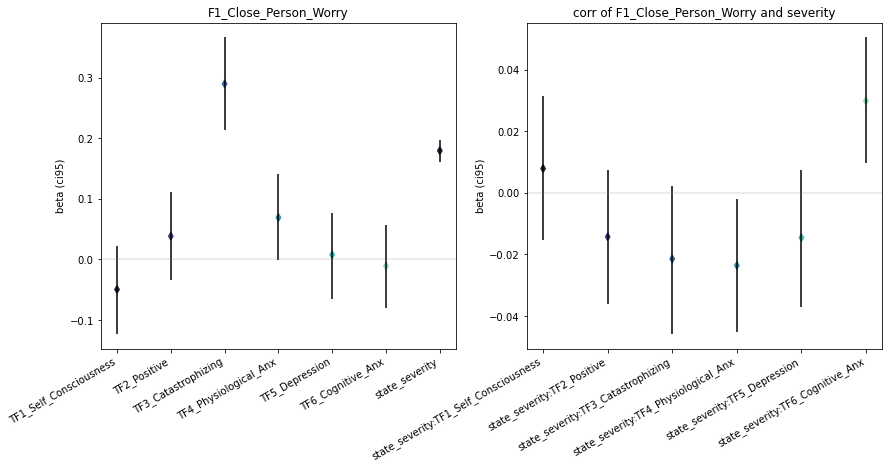

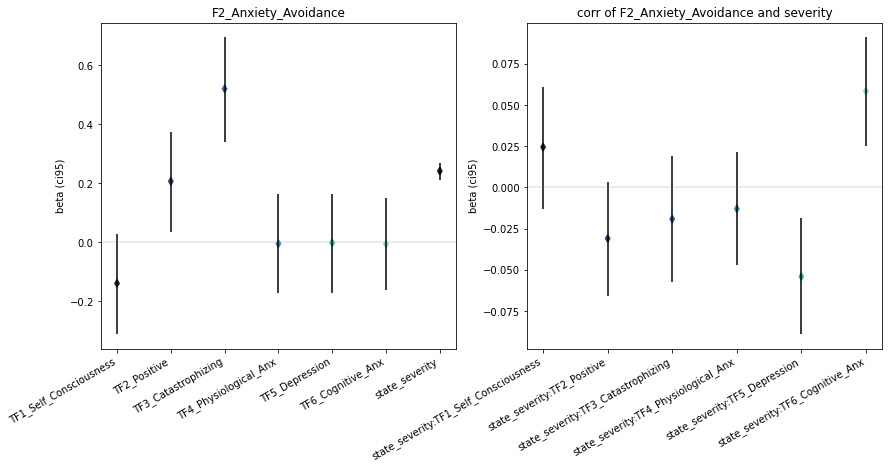

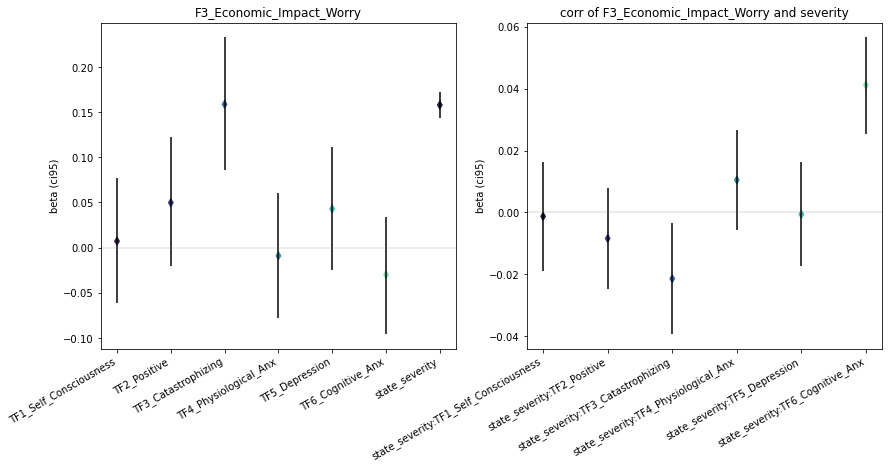

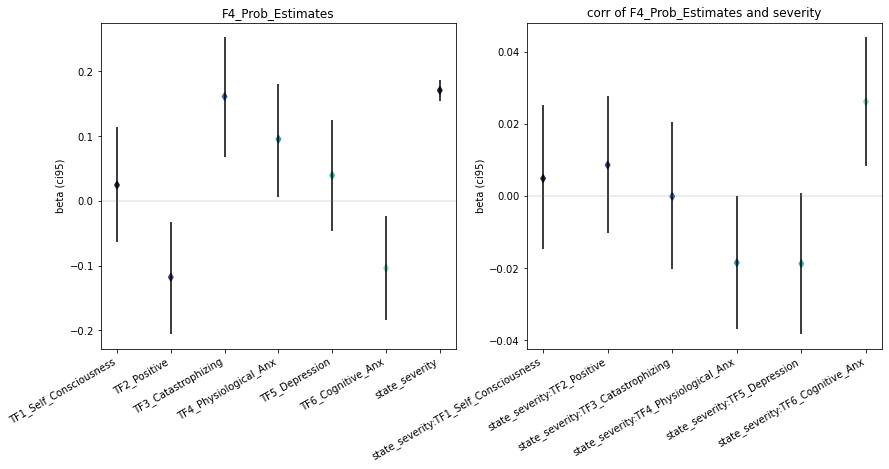

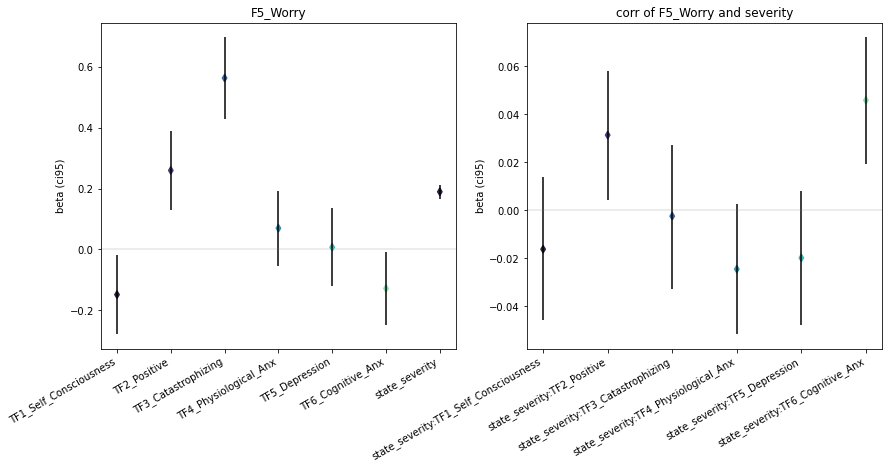

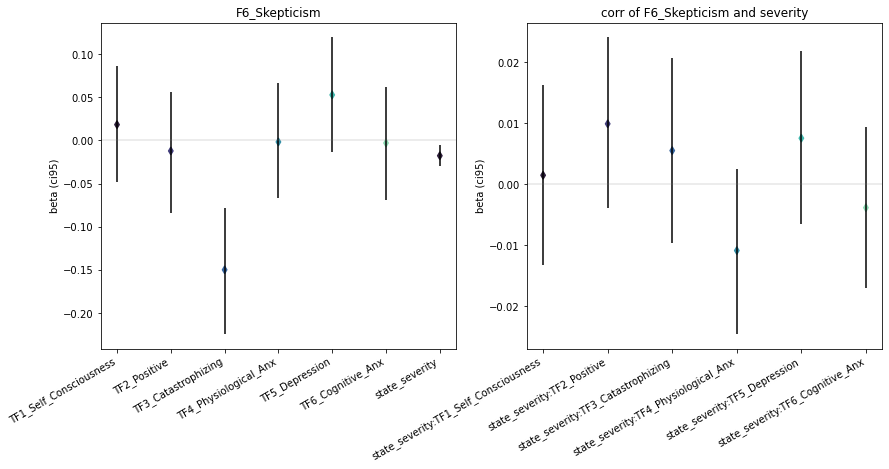

In [9]:
model_constant = "severity_noslope_ND"
folder = "traits_predicting_severity_correlations"
for f_idx, f in enumerate(factors): 
    models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
    mod = models["F"+str(f_idx+1)+"_"+model_constant+"_4_3000"]
    # assumes that models have been estimated
    mod["current_sys_location"] = os.path.join(root_dir, mod["location"])
    mod, res, m = mm.estimate_lmm(mod, [], override=0)
    # add diagnostics
    #az.plot_trace(res)
    display.display(az.summary(res).head(15))

    # PLOT
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    for gr_idx, beta_group in enumerate([trait_factor_names+['state_severity'],['state_severity:'+i for i in trait_factor_names]]):
        tdf = pd.DataFrame()
        for tf in beta_group:
            d = res.posterior[tf].stack(draws=("chain", "draw"))
            dt = pd.DataFrame(d, columns=["sample"])
            dt.loc[:,"trait_factor"] = tf
            tdf = pd.concat([tdf, dt])
        tdf
        axs[gr_idx] = sns.pointplot(x="trait_factor", y= "sample",
                      data=tdf, dodge=.532, join=False, palette=sns.color_palette("mako",6),
                      markers="d", scale=.75, ci=None, ax =axs[gr_idx]);
        bounds = tdf.groupby("trait_factor")['sample'].quantile((0.025,0.975)).unstack().reset_index().sort_values(by="trait_factor")
        axs[gr_idx].vlines(bounds.trait_factor, bounds.iloc[:,1], bounds.iloc[:,2], colors='black')
        axs[gr_idx].axhline(0, alpha=0.2, color='gray')
        if gr_idx == 0:
            axs[gr_idx].set_title(f)
        elif gr_idx == 1:
            axs[gr_idx].set_title("corr of "+f+" and severity")
        axs[gr_idx].set_ylabel("beta (ci95)")
        axs[gr_idx].set_xlabel("")
        axs[gr_idx].set_xticklabels(beta_group, rotation = 30, ha="right")

In [10]:
from IPython import display
pd.set_option('display.max_rows', 500)
results_table = az.summary(res)
results_table.head(20)
# model comparison, nesting might not makes sense, sess only 1 data point
#sess into slpe
m

[]

### With random slopes


#### How to best structure the random effects structure

Simplified example, if we had only two trait factors $TF_1$ and $TF_2$. 
$St$ = state severity

Model 1 (above) ("noslopes")
$$
Worry \sim St + TF_1 + St*TF_1 + TF_2 + St*TF_2 + (sess| id) 
$$



Model 2 - with slopes

$$
Worry \sim St + TF_1 + St*TF_1 + TF_2 + St*TF_2 + (1 + TF_1 + TF_2 + sess | id) 
$$

Model 3 - also with interaction slopes

$$
Worry \sim St + TF_1 + St*TF_1 + TF_2 + St*TF_2 + (1 + TF_1 + St*TF_1 + TF_2 + St*TF_2 + sess | id) 
$$


Model 4  
The random slopes for traits didn't make sense beacuse they are fixed within participant.
What does make sense thought is to model the session as var of interest

$$
Worry \sim St + TF_1 + St*TF_1 + TF_2 + St*TF_2 + TF_1*sess + St*TF_1*sess + TF_2*sess + St*TF_2*sess + (1 + sess | id) 
$$



### Model 2: random slopes  severity + trait + severity\*trait + (1 + trait + session|subject)

Model F1_severity_slopes_ND_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  \
Intercept                              1.618  0.031   1.562    1.676   
state_severity                         0.216  0.016   0.186    0.246   
TF1_Self_Consciousness                -0.068  0.041  -0.141    0.008   
TF2_Positive                           0.031  0.038  -0.040    0.101   
TF3_Catastrophizing                    0.291  0.041   0.216    0.370   
TF4_Physiological_Anx                  0.052  0.038  -0.020    0.122   
TF5_Depression                         0.012  0.039  -0.061    0.086   
TF6_Cognitive_Anx                     -0.000  0.038  -0.071    0.068   
state_severity:TF1_Self_Consciousness  0.014  0.020  -0.020    0.058   
state_severity:TF2_Positive           -0.018  0.019  -0.054    0.019   
state_severity:TF3_Catastrophizing    -0.029  0.020  -0.069    0.008   
state_severity:TF4_Physiological_Anx  -0.033  0.018  -0.068    0.002   
state_severity:TF5_Depression         -0.009  0.019  -0.045    0.026   
state_severity:TF6_Cognitive_Anx       0.021  0.019  -0.015    0.055   
1|PROLIFICID_sigma                     0.417  0.030   0.363    0.473   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept                                  0.001    0.001     979.0    3825.0   
state_severity                             0.001    0.001     445.0    3197.0   
TF1_Self_Consciousness                     0.002    0.002     282.0    3173.0   
TF2_Positive                               0.001    0.001    1914.0    2541.0   
TF3_Catastrophizing                        0.001    0.001    2837.0    2709.0   
TF4_Physiological_Anx                      0.001    0.001    2226.0    2093.0   
TF5_Depression                             0.001    0.001    2697.0    2339.0   
TF6_Cognitive_Anx                          0.003    0.002     169.0     191.0   
state_severity:TF1_Self_Consciousness      0.001    0.001    1164.0     347.0   
state_severity:TF2_Positive                0.000    0.000    2618.0    3008.0   
state_severity:TF3_Catastrophizing         0.000    0.000    2442.0    1657.0   
state_severity:TF4_Physiological_Anx       0.000    0.000    3835.0    3368.0   
state_severity:TF5_Depression              0.001    0.001     494.0    2300.0   
state_severity:TF6_Cognitive_Anx           0.000    0.000    3338.0    3063.0   
1|PROLIFICID_sigma                         0.001    0.001     460.0    1911.0   

                                       r_hat  
Intercept                               1.01  
state_severity                          1.01  
TF1_Self_Consciousness                  1.02  
TF2_Positive                            1.01  
TF3_Catastrophizing                     1.01  
TF4_Physiological_Anx                   1.01  
TF5_Depression                          1.01  
TF6_Cognitive_Anx                       1.02  
state_severity:TF1_Self_Consciousness   1.02  
state_severity:TF2_Positive             1.00  
state_severity:TF3_Catastrophizing      1.01  
state_severity:TF4_Physiological_Anx    1.01  
state_severity:TF5_Depression           1.01  
state_severity:TF6_Cognitive_Anx        1.01  
1|PROLIFICID_sigma                      1.01

Model F2_severity_slopes_ND_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  \
Intercept                              3.921  0.076   3.773    4.057   
state_severity                         0.292  0.025   0.244    0.340   
TF1_Self_Consciousness                -0.186  0.098  -0.376   -0.020   
TF2_Positive                           0.203  0.091   0.039    0.392   
TF3_Catastrophizing                    0.503  0.097   0.321    0.675   
TF4_Physiological_Anx                 -0.034  0.087  -0.202    0.123   
TF5_Depression                         0.004  0.088  -0.153    0.172   
TF6_Cognitive_Anx                     -0.013  0.088  -0.176    0.147   
state_severity:TF1_Self_Consciousness  0.027  0.033  -0.037    0.085   
state_severity:TF2_Positive           -0.035  0.031  -0.091    0.021   
state_severity:TF3_Catastrophizing    -0.038  0.033  -0.102    0.024   
state_severity:TF4_Physiological_Anx  -0.014  0.032  -0.064    0.056   
state_severity:TF5_Depression         -0.049  0.029  -0.104    0.006   
state_severity:TF6_Cognitive_Anx       0.046  0.030  -0.010    0.104   
1|PROLIFICID_sigma                     1.025  0.070   0.897    1.158   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept                                  0.005    0.003     272.0     217.0   
state_severity                             0.001    0.001     949.0    1410.0   
TF1_Self_Consciousness                     0.007    0.006     229.0     273.0   
TF2_Positive                               0.004    0.003     575.0     247.0   
TF3_Catastrophizing                        0.006    0.005     239.0     338.0   
TF4_Physiological_Anx                      0.003    0.002     712.0    1182.0   
TF5_Depression                             0.005    0.004     282.0     161.0   
TF6_Cognitive_Anx                          0.004    0.003     601.0     781.0   
state_severity:TF1_Self_Consciousness      0.002    0.002     241.0     427.0   
state_severity:TF2_Positive                0.001    0.001     850.0    3354.0   
state_severity:TF3_Catastrophizing         0.002    0.001     383.0     286.0   
state_severity:TF4_Physiological_Anx       0.003    0.002     105.0      60.0   
state_severity:TF5_Depression              0.001    0.000    1814.0    3941.0   
state_severity:TF6_Cognitive_Anx           0.001    0.001     447.0     234.0   
1|PROLIFICID_sigma                         0.004    0.003     346.0     671.0   

                                       r_hat  
Intercept                               1.01  
state_severity                          1.01  
TF1_Self_Consciousness                  1.02  
TF2_Positive                            1.01  
TF3_Catastrophizing                     1.02  
TF4_Physiological_Anx                   1.01  
TF5_Depression                          1.03  
TF6_Cognitive_Anx                       1.01  
state_severity:TF1_Self_Consciousness   1.02  
state_severity:TF2_Positive             1.00  
state_severity:TF3_Catastrophizing      1.01  
state_severity:TF4_Physiological_Anx    1.03  
state_severity:TF5_Depression           1.01  
state_severity:TF6_Cognitive_Anx        1.01  
1|PROLIFICID_sigma                      1.02

Model F3_severity_slopes_ND_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  \
Intercept                              1.149  0.029   1.088    1.199   
state_severity                         0.171  0.010   0.151    0.189   
TF1_Self_Consciousness                 0.011  0.041  -0.069    0.085   
TF2_Positive                           0.052  0.035  -0.017    0.112   
TF3_Catastrophizing                    0.166  0.037   0.081    0.227   
TF4_Physiological_Anx                 -0.017  0.038  -0.082    0.051   
TF5_Depression                         0.033  0.038  -0.026    0.118   
TF6_Cognitive_Anx                     -0.034  0.033  -0.093    0.032   
state_severity:TF1_Self_Consciousness  0.013  0.014  -0.013    0.039   
state_severity:TF2_Positive           -0.006  0.013  -0.030    0.018   
state_severity:TF3_Catastrophizing    -0.020  0.014  -0.042    0.014   
state_severity:TF4_Physiological_Anx   0.002  0.012  -0.022    0.025   
state_severity:TF5_Depression          0.005  0.014  -0.023    0.027   
state_severity:TF6_Cognitive_Anx       0.021  0.014  -0.002    0.048   
1|PROLIFICID_sigma                     0.429  0.029   0.361    0.475   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept                                  0.004    0.003      50.0      78.0   
state_severity                             0.001    0.001      90.0     641.0   
TF1_Self_Consciousness                     0.006    0.005      48.0      19.0   
TF2_Positive                               0.004    0.003      75.0      95.0   
TF3_Catastrophizing                        0.003    0.002     180.0     124.0   
TF4_Physiological_Anx                      0.008    0.005      26.0     258.0   
TF5_Depression                             0.006    0.006      40.0      26.0   
TF6_Cognitive_Anx                          0.002    0.002     201.0     277.0   
state_severity:TF1_Self_Consciousness      0.002    0.001      66.0     217.0   
state_severity:TF2_Positive                0.001    0.001     167.0    1892.0   
state_severity:TF3_Catastrophizing         0.002    0.001      63.0      24.0   
state_severity:TF4_Physiological_Anx       0.001    0.000     435.0     780.0   
state_severity:TF5_Depression              0.002    0.001      52.0      42.0   
state_severity:TF6_Cognitive_Anx           0.003    0.002      22.0     210.0   
1|PROLIFICID_sigma                         0.004    0.003      63.0      27.0   

                                       r_hat  
Intercept                               1.06  
state_severity                          1.07  
TF1_Self_Consciousness                  1.06  
TF2_Positive                            1.05  
TF3_Catastrophizing                     1.06  
TF4_Physiological_Anx                   1.11  
TF5_Depression                          1.07  
TF6_Cognitive_Anx                       1.07  
state_severity:TF1_Self_Consciousness   1.04  
state_severity:TF2_Positive             1.08  
state_severity:TF3_Catastrophizing      1.05  
state_severity:TF4_Physiological_Anx    1.03  
state_severity:TF5_Depression           1.05  
state_severity:TF6_Cognitive_Anx        1.12  
1|PROLIFICID_sigma                      1.13

Model F4_severity_slopes_ND_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  \
Intercept                              1.114  0.039   1.059    1.187   
state_severity                         0.184  0.015   0.153    0.213   
TF1_Self_Consciousness                 0.027  0.042  -0.060    0.102   
TF2_Positive                          -0.114  0.039  -0.197   -0.041   
TF3_Catastrophizing                    0.136  0.053   0.063    0.231   
TF4_Physiological_Anx                  0.110  0.043   0.022    0.181   
TF5_Depression                         0.021  0.060  -0.084    0.114   
TF6_Cognitive_Anx                     -0.090  0.042  -0.174   -0.027   
state_severity:TF1_Self_Consciousness  0.013  0.020  -0.021    0.055   
state_severity:TF2_Positive            0.007  0.021  -0.029    0.038   
state_severity:TF3_Catastrophizing    -0.005  0.022  -0.050    0.026   
state_severity:TF4_Physiological_Anx   0.002  0.018  -0.034    0.030   
state_severity:TF5_Depression         -0.025  0.023  -0.063    0.012   
state_severity:TF6_Cognitive_Anx       0.006  0.016  -0.025    0.037   
1|PROLIFICID_sigma                     0.512  0.036   0.449    0.580   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept                                  0.012    0.009      13.0     840.0   
state_severity                             0.004    0.003      16.0      22.0   
TF1_Self_Consciousness                     0.007    0.005      36.0     887.0   
TF2_Positive                               0.005    0.004      44.0     389.0   
TF3_Catastrophizing                        0.016    0.012      12.0     662.0   
TF4_Physiological_Anx                      0.009    0.007      24.0     249.0   
TF5_Depression                             0.023    0.017       7.0      16.0   
TF6_Cognitive_Anx                          0.010    0.007      20.0     334.0   
state_severity:TF1_Self_Consciousness      0.006    0.005      16.0      29.0   
state_severity:TF2_Positive                0.007    0.005       9.0      66.0   
state_severity:TF3_Catastrophizing         0.006    0.005      17.0      34.0   
state_severity:TF4_Physiological_Anx       0.004    0.003      21.0     334.0   
state_severity:TF5_Depression              0.009    0.007       7.0      47.0   
state_severity:TF6_Cognitive_Anx           0.001    0.002     324.0     440.0   
1|PROLIFICID_sigma                         0.010    0.007      14.0      52.0   

                                       r_hat  
Intercept                               1.23  
state_severity                          1.19  
TF1_Self_Consciousness                  1.16  
TF2_Positive                            1.11  
TF3_Catastrophizing                     1.24  
TF4_Physiological_Anx                   1.12  
TF5_Depression                          1.51  
TF6_Cognitive_Anx                       1.14  
state_severity:TF1_Self_Consciousness   1.45  
state_severity:TF2_Positive             1.36  
state_severity:TF3_Catastrophizing      1.28  
state_severity:TF4_Physiological_Anx    1.21  
state_severity:TF5_Depression           1.49  
state_severity:TF6_Cognitive_Anx        1.18  
1|PROLIFICID_sigma                      1.24

Model F5_severity_slopes_ND_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  \
Intercept                              2.223  0.052   2.122    2.320   
state_severity                         0.227  0.021   0.189    0.265   
TF1_Self_Consciousness                -0.167  0.074  -0.294   -0.015   
TF2_Positive                           0.257  0.066   0.130    0.381   
TF3_Catastrophizing                    0.552  0.074   0.421    0.690   
TF4_Physiological_Anx                  0.041  0.076  -0.103    0.194   
TF5_Depression                         0.027  0.070  -0.114    0.157   
TF6_Cognitive_Anx                     -0.120  0.061  -0.241   -0.005   
state_severity:TF1_Self_Consciousness -0.009  0.025  -0.054    0.036   
state_severity:TF2_Positive            0.030  0.023  -0.018    0.073   
state_severity:TF3_Catastrophizing    -0.006  0.025  -0.054    0.040   
state_severity:TF4_Physiological_Anx  -0.040  0.023  -0.080    0.005   
state_severity:TF5_Depression         -0.010  0.025  -0.054    0.037   
state_severity:TF6_Cognitive_Anx       0.025  0.023  -0.016    0.068   
1|PROLIFICID_sigma                     0.778  0.051   0.677    0.868   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept                                  0.002    0.001    1032.0    1849.0   
state_severity                             0.001    0.001     222.0     633.0   
TF1_Self_Consciousness                     0.006    0.004     170.0      32.0   
TF2_Positive                               0.002    0.002     763.0    1580.0   
TF3_Catastrophizing                        0.004    0.003     291.0     603.0   
TF4_Physiological_Anx                      0.012    0.008      44.0      32.0   
TF5_Depression                             0.003    0.004     554.0     210.0   
TF6_Cognitive_Anx                          0.002    0.001    1563.0    3533.0   
state_severity:TF1_Self_Consciousness      0.001    0.001     334.0    1270.0   
state_severity:TF2_Positive                0.001    0.001    1134.0     701.0   
state_severity:TF3_Catastrophizing         0.001    0.001     576.0    1098.0   
state_severity:TF4_Physiological_Anx       0.001    0.001     520.0    2232.0   
state_severity:TF5_Depression              0.002    0.001     244.0     981.0   
state_severity:TF6_Cognitive_Anx           0.001    0.001     350.0    1209.0   
1|PROLIFICID_sigma                         0.003    0.002     245.0      97.0   

                                       r_hat  
Intercept                               1.01  
state_severity                          1.02  
TF1_Self_Consciousness                  1.03  
TF2_Positive                            1.01  
TF3_Catastrophizing                     1.01  
TF4_Physiological_Anx                   1.07  
TF5_Depression                          1.02  
TF6_Cognitive_Anx                       1.02  
state_severity:TF1_Self_Consciousness   1.01  
state_severity:TF2_Positive             1.02  
state_severity:TF3_Catastrophizing      1.01  
state_severity:TF4_Physiological_Anx    1.01  
state_severity:TF5_Depression           1.02  
state_severity:TF6_Cognitive_Anx        1.02  
1|PROLIFICID_sigma                      1.03

Model F6_severity_slopes_ND_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  \
Intercept                             -0.031  0.029  -0.091    0.020   
state_severity                        -0.021  0.009  -0.036   -0.004   
TF1_Self_Consciousness                 0.035  0.039  -0.040    0.105   
TF2_Positive                          -0.024  0.036  -0.092    0.042   
TF3_Catastrophizing                   -0.137  0.041  -0.216   -0.064   
TF4_Physiological_Anx                 -0.004  0.037  -0.075    0.065   
TF5_Depression                         0.062  0.038  -0.013    0.128   
TF6_Cognitive_Anx                     -0.003  0.036  -0.073    0.061   
state_severity:TF1_Self_Consciousness -0.000  0.011  -0.021    0.021   
state_severity:TF2_Positive            0.004  0.011  -0.015    0.025   
state_severity:TF3_Catastrophizing     0.006  0.011  -0.016    0.027   
state_severity:TF4_Physiological_Anx  -0.014  0.010  -0.032    0.006   
state_severity:TF5_Depression          0.011  0.011  -0.009    0.030   
state_severity:TF6_Cognitive_Anx       0.001  0.010  -0.018    0.019   
1|PROLIFICID_sigma                     0.397  0.032   0.336    0.457   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept                                  0.001    0.001    1409.0    1607.0   
state_severity                             0.000    0.000    2711.0    5553.0   
TF1_Self_Consciousness                     0.001    0.001    1906.0    2976.0   
TF2_Positive                               0.001    0.001    1998.0    3386.0   
TF3_Catastrophizing                        0.001    0.001    1586.0    2627.0   
TF4_Physiological_Anx                      0.001    0.001    1274.0     772.0   
TF5_Depression                             0.001    0.001    1683.0    1359.0   
TF6_Cognitive_Anx                          0.001    0.001    2122.0    3221.0   
state_severity:TF1_Self_Consciousness      0.000    0.000    2093.0    3525.0   
state_severity:TF2_Positive                0.000    0.000    1668.0    4369.0   
state_severity:TF3_Catastrophizing         0.000    0.000    2778.0    3365.0   
state_severity:TF4_Physiological_Anx       0.000    0.000    3294.0    5101.0   
state_severity:TF5_Depression              0.000    0.000    2454.0    5454.0   
state_severity:TF6_Cognitive_Anx           0.000    0.000    3060.0    4770.0   
1|PROLIFICID_sigma                         0.002    0.001     406.0    1175.0   

                                       r_hat  
Intercept                               1.00  
state_severity                          1.00  
TF1_Self_Consciousness                  1.01  
TF2_Positive                            1.00  
TF3_Catastrophizing                     1.00  
TF4_Physiological_Anx                   1.00  
TF5_Depression                          1.00  
TF6_Cognitive_Anx                       1.00  
state_severity:TF1_Self_Consciousness   1.00  
state_severity:TF2_Positive             1.01  
state_severity:TF3_Catastrophizing      1.00  
state_severity:TF4_Physiological_Anx    1.00  
state_severity:TF5_Depression           1.00  
state_severity:TF6_Cognitive_Anx        1.00  
1|PROLIFICID_sigma                      1.02

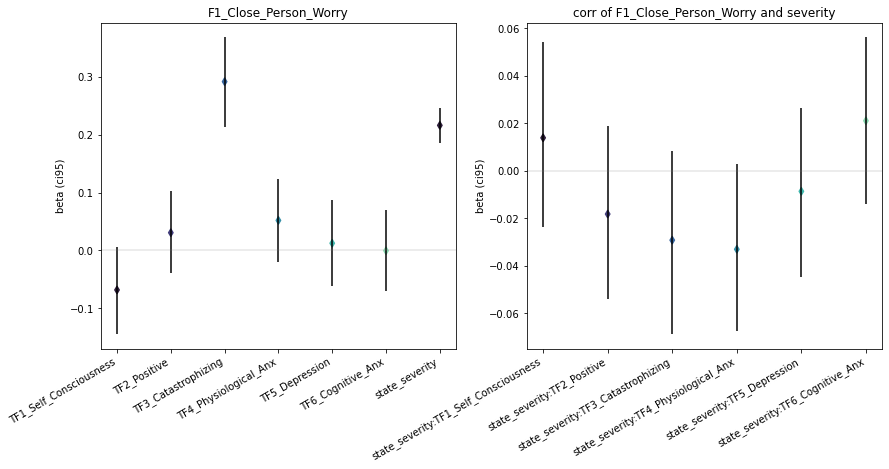

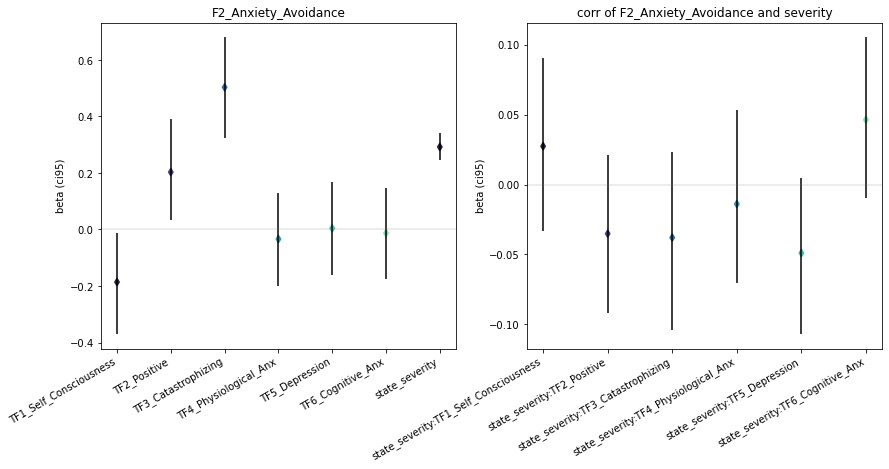

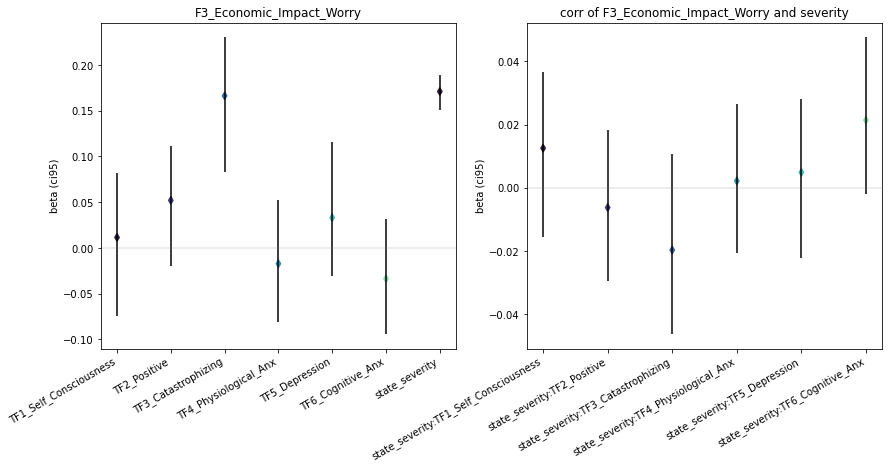

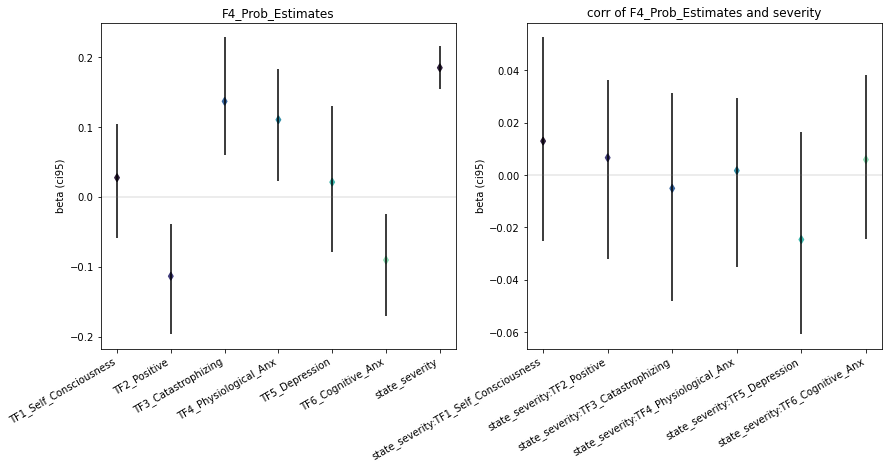

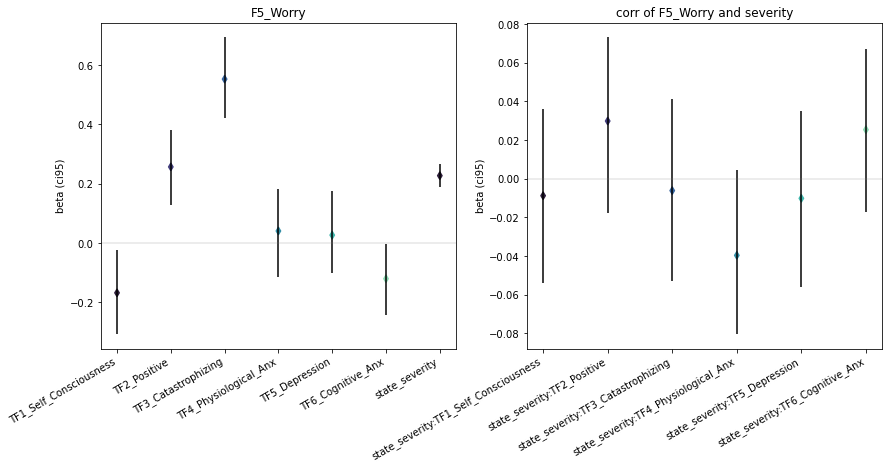

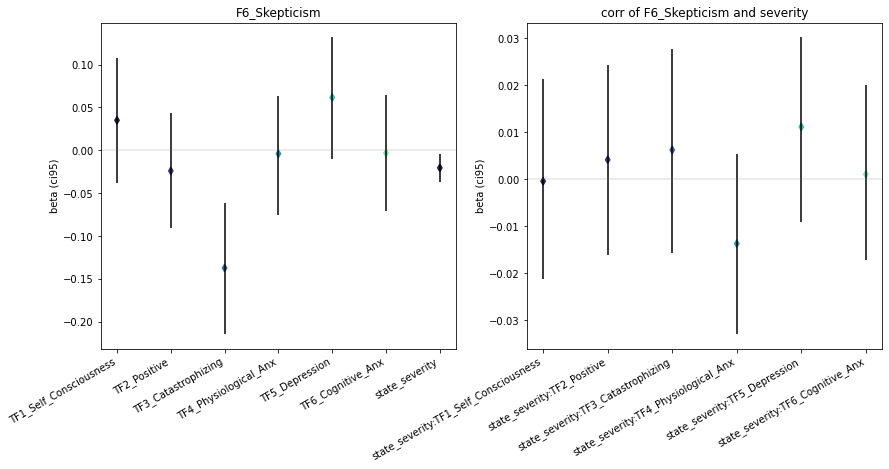

In [11]:
model_constant = "severity_slopes_ND"
folder = "traits_predicting_severity_correlations"
for f_idx, f in enumerate(factors): 
    models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
    mod = models["F"+str(f_idx+1)+"_"+model_constant+"_4_3000"]
    # assumes that models have been estimated
    mod["current_sys_location"] = os.path.join(root_dir, mod["location"])
    mod, res, m = mm.estimate_lmm(mod, [], override=0)
    # add diagnostics
    #az.plot_trace(res)
    display.display(az.summary(res).head(15))

    # PLOT
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    for gr_idx, beta_group in enumerate([trait_factor_names+['state_severity'],['state_severity:'+i for i in trait_factor_names]]):
        tdf = pd.DataFrame()
        for tf in beta_group:
            d = res.posterior[tf].stack(draws=("chain", "draw"))
            dt = pd.DataFrame(d, columns=["sample"])
            dt.loc[:,"trait_factor"] = tf
            tdf = pd.concat([tdf, dt])
        tdf
        axs[gr_idx] = sns.pointplot(x="trait_factor", y= "sample",
                      data=tdf, dodge=.532, join=False, palette=sns.color_palette("mako",6),
                      markers="d", scale=.75, ci=None, ax =axs[gr_idx]);
        bounds = tdf.groupby("trait_factor")['sample'].quantile((0.03,0.97)).unstack().reset_index().sort_values(by="trait_factor")
        axs[gr_idx].vlines(bounds.trait_factor, bounds.iloc[:,1], bounds.iloc[:,2], colors='black')
        axs[gr_idx].axhline(0, alpha=0.2, color='gray')
        if gr_idx == 0:
            axs[gr_idx].set_title(f)
        elif gr_idx == 1:
            axs[gr_idx].set_title("corr of "+f+" and severity")
        axs[gr_idx].set_ylabel("beta (ci95)")
        axs[gr_idx].set_xlabel("")
        axs[gr_idx].set_xticklabels(beta_group, rotation = 30, ha="right")

### Model 3: random slopes and interactions  severity + trait + severity\*trait + (1 + trait + session + trait\*severity|subject)

Model F1_severity_maxmodel_ND_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  \
Intercept                              1.619  0.032   1.554    1.674   
state_severity                         0.215  0.016   0.185    0.245   
TF1_Self_Consciousness                -0.068  0.040  -0.142    0.006   
TF2_Positive                           0.032  0.039  -0.041    0.104   
TF3_Catastrophizing                    0.289  0.042   0.214    0.369   
TF4_Physiological_Anx                  0.056  0.038  -0.016    0.127   
TF5_Depression                         0.017  0.040  -0.059    0.092   
TF6_Cognitive_Anx                      0.001  0.037  -0.064    0.074   
state_severity:TF1_Self_Consciousness  0.010  0.021  -0.029    0.051   
state_severity:TF2_Positive           -0.019  0.019  -0.055    0.018   
state_severity:TF3_Catastrophizing    -0.026  0.022  -0.066    0.015   
state_severity:TF4_Physiological_Anx  -0.024  0.020  -0.061    0.013   
state_severity:TF5_Depression         -0.011  0.020  -0.050    0.026   
state_severity:TF6_Cognitive_Anx       0.013  0.021  -0.025    0.053   
1|PROLIFICID_sigma                     0.418  0.032   0.358    0.477   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept                                  0.001    0.001    1585.0     963.0   
state_severity                             0.000    0.000    3548.0    4488.0   
TF1_Self_Consciousness                     0.001    0.001    1893.0    3766.0   
TF2_Positive                               0.001    0.001    2234.0    3684.0   
TF3_Catastrophizing                        0.001    0.001    2065.0    1414.0   
TF4_Physiological_Anx                      0.001    0.001    2774.0    3124.0   
TF5_Depression                             0.001    0.001     811.0     314.0   
TF6_Cognitive_Anx                          0.001    0.001    1882.0    3010.0   
state_severity:TF1_Self_Consciousness      0.000    0.000    4528.0    4995.0   
state_severity:TF2_Positive                0.000    0.000    3877.0    5332.0   
state_severity:TF3_Catastrophizing         0.000    0.000    3460.0    3297.0   
state_severity:TF4_Physiological_Anx       0.000    0.000    1928.0    3068.0   
state_severity:TF5_Depression              0.000    0.000    3760.0    5532.0   
state_severity:TF6_Cognitive_Anx           0.000    0.000    2939.0    4081.0   
1|PROLIFICID_sigma                         0.002    0.001     383.0     144.0   

                                       r_hat  
Intercept                               1.01  
state_severity                          1.00  
TF1_Self_Consciousness                  1.00  
TF2_Positive                            1.00  
TF3_Catastrophizing                     1.00  
TF4_Physiological_Anx                   1.00  
TF5_Depression                          1.01  
TF6_Cognitive_Anx                       1.00  
state_severity:TF1_Self_Consciousness   1.00  
state_severity:TF2_Positive             1.00  
state_severity:TF3_Catastrophizing      1.00  
state_severity:TF4_Physiological_Anx    1.00  
state_severity:TF5_Depression           1.00  
state_severity:TF6_Cognitive_Anx        1.00  
1|PROLIFICID_sigma                      1.02

Model F2_severity_maxmodel_ND_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  \
Intercept                              3.894  0.079   3.793    4.049   
state_severity                         0.288  0.023   0.245    0.336   
TF1_Self_Consciousness                -0.178  0.081  -0.332   -0.011   
TF2_Positive                           0.205  0.080   0.047    0.359   
TF3_Catastrophizing                    0.472  0.107   0.315    0.666   
TF4_Physiological_Anx                 -0.014  0.084  -0.191    0.120   
TF5_Depression                        -0.007  0.078  -0.149    0.163   
TF6_Cognitive_Anx                      0.006  0.082  -0.166    0.133   
state_severity:TF1_Self_Consciousness  0.039  0.036  -0.035    0.089   
state_severity:TF2_Positive           -0.041  0.033  -0.091    0.028   
state_severity:TF3_Catastrophizing    -0.040  0.031  -0.105    0.018   
state_severity:TF4_Physiological_Anx  -0.008  0.029  -0.069    0.046   
state_severity:TF5_Depression         -0.054  0.029  -0.107    0.007   
state_severity:TF6_Cognitive_Anx       0.042  0.029  -0.004    0.105   
1|PROLIFICID_sigma                     1.003  0.080   0.899    1.153   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept                                  0.024    0.017      12.0     686.0   
state_severity                             0.001    0.000    1488.0    2909.0   
TF1_Self_Consciousness                     0.002    0.002    1338.0    1931.0   
TF2_Positive                               0.005    0.003     199.0    1952.0   
TF3_Catastrophizing                        0.033    0.024      11.0      72.0   
TF4_Physiological_Anx                      0.016    0.011      32.0    1986.0   
TF5_Depression                             0.002    0.008    1502.0    2942.0   
TF6_Cognitive_Anx                          0.018    0.013      24.0    1377.0   
state_severity:TF1_Self_Consciousness      0.009    0.007      16.0     915.0   
state_severity:TF2_Positive                0.007    0.005      24.0    3218.0   
state_severity:TF3_Catastrophizing         0.001    0.003    1048.0    3406.0   
state_severity:TF4_Physiological_Anx       0.003    0.003     146.0    1925.0   
state_severity:TF5_Depression              0.003    0.002     176.0     747.0   
state_severity:TF6_Cognitive_Anx           0.005    0.004      43.0    1521.0   
1|PROLIFICID_sigma                         0.026    0.019      10.0     429.0   

                                       r_hat  
Intercept                               1.25  
state_severity                          1.25  
TF1_Self_Consciousness                  1.25  
TF2_Positive                            1.19  
TF3_Catastrophizing                     1.28  
TF4_Physiological_Anx                   1.08  
TF5_Depression                          1.26  
TF6_Cognitive_Anx                       1.12  
state_severity:TF1_Self_Consciousness   1.17  
state_severity:TF2_Positive             1.11  
state_severity:TF3_Catastrophizing      1.20  
state_severity:TF4_Physiological_Anx    1.11  
state_severity:TF5_Depression           1.20  
state_severity:TF6_Cognitive_Anx        1.11  
1|PROLIFICID_sigma                      1.30

Model F3_severity_maxmodel_ND_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  \
Intercept                              1.145  0.029   1.089    1.197   
state_severity                         0.169  0.011   0.147    0.190   
TF1_Self_Consciousness                 0.018  0.038  -0.059    0.083   
TF2_Positive                           0.043  0.037  -0.023    0.114   
TF3_Catastrophizing                    0.164  0.042   0.085    0.244   
TF4_Physiological_Anx                 -0.012  0.038  -0.084    0.056   
TF5_Depression                         0.030  0.037  -0.038    0.101   
TF6_Cognitive_Anx                     -0.033  0.035  -0.096    0.035   
state_severity:TF1_Self_Consciousness  0.012  0.015  -0.015    0.041   
state_severity:TF2_Positive           -0.007  0.014  -0.032    0.021   
state_severity:TF3_Catastrophizing    -0.020  0.015  -0.049    0.007   
state_severity:TF4_Physiological_Anx   0.004  0.014  -0.021    0.030   
state_severity:TF5_Depression          0.004  0.014  -0.021    0.031   
state_severity:TF6_Cognitive_Anx       0.021  0.014  -0.005    0.046   
1|PROLIFICID_sigma                     0.429  0.027   0.374    0.475   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept                                  0.001    0.001    1048.0    3615.0   
state_severity                             0.000    0.000    2458.0    3606.0   
TF1_Self_Consciousness                     0.001    0.001    1247.0     729.0   
TF2_Positive                               0.001    0.001    1190.0    3081.0   
TF3_Catastrophizing                        0.002    0.001     548.0     267.0   
TF4_Physiological_Anx                      0.002    0.001     601.0     373.0   
TF5_Depression                             0.001    0.001    1327.0    2501.0   
TF6_Cognitive_Anx                          0.001    0.001     660.0    1489.0   
state_severity:TF1_Self_Consciousness      0.000    0.000    1640.0    3769.0   
state_severity:TF2_Positive                0.000    0.000    1619.0    1525.0   
state_severity:TF3_Catastrophizing         0.000    0.000    2148.0    2119.0   
state_severity:TF4_Physiological_Anx       0.000    0.000    1413.0    4658.0   
state_severity:TF5_Depression              0.000    0.000    1473.0    2368.0   
state_severity:TF6_Cognitive_Anx           0.000    0.000    1134.0     796.0   
1|PROLIFICID_sigma                         0.001    0.001     878.0     635.0   

                                       r_hat  
Intercept                               1.01  
state_severity                          1.00  
TF1_Self_Consciousness                  1.00  
TF2_Positive                            1.00  
TF3_Catastrophizing                     1.01  
TF4_Physiological_Anx                   1.01  
TF5_Depression                          1.00  
TF6_Cognitive_Anx                       1.00  
state_severity:TF1_Self_Consciousness   1.00  
state_severity:TF2_Positive             1.00  
state_severity:TF3_Catastrophizing      1.00  
state_severity:TF4_Physiological_Anx    1.00  
state_severity:TF5_Depression           1.01  
state_severity:TF6_Cognitive_Anx        1.00  
1|PROLIFICID_sigma                      1.00

Model F4_severity_maxmodel_ND_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  \
Intercept                              1.123  0.041   1.043    1.192   
state_severity                         0.191  0.016   0.164    0.222   
TF1_Self_Consciousness                 0.017  0.047  -0.067    0.108   
TF2_Positive                          -0.117  0.046  -0.205   -0.035   
TF3_Catastrophizing                    0.153  0.053   0.056    0.254   
TF4_Physiological_Anx                  0.097  0.045   0.014    0.185   
TF5_Depression                         0.053  0.047  -0.033    0.147   
TF6_Cognitive_Anx                     -0.097  0.044  -0.179   -0.015   
state_severity:TF1_Self_Consciousness  0.008  0.021  -0.033    0.045   
state_severity:TF2_Positive           -0.002  0.020  -0.041    0.033   
state_severity:TF3_Catastrophizing     0.002  0.021  -0.036    0.042   
state_severity:TF4_Physiological_Anx  -0.003  0.021  -0.042    0.036   
state_severity:TF5_Depression         -0.017  0.023  -0.061    0.026   
state_severity:TF6_Cognitive_Anx       0.002  0.019  -0.035    0.039   
1|PROLIFICID_sigma                     0.518  0.040   0.450    0.597   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept                                  0.006    0.004      53.0      64.0   
state_severity                             0.000    0.000    1201.0    2341.0   
TF1_Self_Consciousness                     0.002    0.001     490.0    2943.0   
TF2_Positive                               0.003    0.002     262.0    2511.0   
TF3_Catastrophizing                        0.002    0.002     628.0     376.0   
TF4_Physiological_Anx                      0.001    0.001    1159.0    2776.0   
TF5_Depression                             0.002    0.001     753.0     472.0   
TF6_Cognitive_Anx                          0.001    0.001     974.0    1610.0   
state_severity:TF1_Self_Consciousness      0.001    0.000    1671.0    3670.0   
state_severity:TF2_Positive                0.001    0.001     201.0     787.0   
state_severity:TF3_Catastrophizing         0.001    0.000     953.0    3054.0   
state_severity:TF4_Physiological_Anx       0.002    0.002      99.0     142.0   
state_severity:TF5_Depression              0.003    0.002      82.0      69.0   
state_severity:TF6_Cognitive_Anx           0.000    0.000    1618.0    1872.0   
1|PROLIFICID_sigma                         0.003    0.002     202.0     298.0   

                                       r_hat  
Intercept                               1.06  
state_severity                          1.01  
TF1_Self_Consciousness                  1.02  
TF2_Positive                            1.03  
TF3_Catastrophizing                     1.01  
TF4_Physiological_Anx                   1.01  
TF5_Depression                          1.02  
TF6_Cognitive_Anx                       1.04  
state_severity:TF1_Self_Consciousness   1.01  
state_severity:TF2_Positive             1.03  
state_severity:TF3_Catastrophizing      1.01  
state_severity:TF4_Physiological_Anx    1.04  
state_severity:TF5_Depression           1.05  
state_severity:TF6_Cognitive_Anx        1.01  
1|PROLIFICID_sigma                      1.03

Model F5_severity_maxmodel_ND_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  \
Intercept                              2.224  0.047   2.133    2.317   
state_severity                         0.231  0.019   0.192    0.265   
TF1_Self_Consciousness                -0.157  0.063  -0.292   -0.049   
TF2_Positive                           0.257  0.059   0.141    0.378   
TF3_Catastrophizing                    0.546  0.065   0.414    0.673   
TF4_Physiological_Anx                  0.023  0.064  -0.076    0.162   
TF5_Depression                         0.050  0.071  -0.084    0.153   
TF6_Cognitive_Anx                     -0.148  0.072  -0.246   -0.017   
state_severity:TF1_Self_Consciousness -0.001  0.027  -0.052    0.044   
state_severity:TF2_Positive            0.018  0.030  -0.034    0.068   
state_severity:TF3_Catastrophizing    -0.007  0.024  -0.050    0.041   
state_severity:TF4_Physiological_Anx  -0.038  0.023  -0.078    0.009   
state_severity:TF5_Depression         -0.009  0.026  -0.054    0.039   
state_severity:TF6_Cognitive_Anx       0.021  0.022  -0.019    0.068   
1|PROLIFICID_sigma                     0.776  0.044   0.692    0.864   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept                                  0.002    0.002     389.0     928.0   
state_severity                             0.002    0.002      73.0    1955.0   
TF1_Self_Consciousness                     0.007    0.006      79.0     561.0   
TF2_Positive                               0.001    0.001    1459.0    1249.0   
TF3_Catastrophizing                        0.002    0.001     894.0     713.0   
TF4_Physiological_Anx                      0.011    0.008      36.0     680.0   
TF5_Depression                             0.020    0.015      13.0     384.0   
TF6_Cognitive_Anx                          0.023    0.018      10.0     220.0   
state_severity:TF1_Self_Consciousness      0.006    0.005      18.0     233.0   
state_severity:TF2_Positive                0.010    0.008       9.0      18.0   
state_severity:TF3_Catastrophizing         0.002    0.001     130.0    1472.0   
state_severity:TF4_Physiological_Anx       0.004    0.003      39.0    1097.0   
state_severity:TF5_Depression              0.006    0.004      17.0      41.0   
state_severity:TF6_Cognitive_Anx           0.002    0.002      91.0    2194.0   
1|PROLIFICID_sigma                         0.003    0.002     199.0     771.0   

                                       r_hat  
Intercept                               1.13  
state_severity                          1.10  
TF1_Self_Consciousness                  1.15  
TF2_Positive                            1.21  
TF3_Catastrophizing                     1.18  
TF4_Physiological_Anx                   1.12  
TF5_Depression                          1.22  
TF6_Cognitive_Anx                       1.30  
state_severity:TF1_Self_Consciousness   1.15  
state_severity:TF2_Positive             1.37  
state_severity:TF3_Catastrophizing      1.06  
state_severity:TF4_Physiological_Anx    1.11  
state_severity:TF5_Depression           1.15  
state_severity:TF6_Cognitive_Anx        1.11  
1|PROLIFICID_sigma                      1.07

Model F6_severity_maxmodel_ND_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  \
Intercept                             -0.030  0.029  -0.084    0.024   
state_severity                        -0.020  0.009  -0.037   -0.004   
TF1_Self_Consciousness                 0.036  0.038  -0.035    0.111   
TF2_Positive                          -0.026  0.037  -0.097    0.041   
TF3_Catastrophizing                   -0.138  0.040  -0.214   -0.067   
TF4_Physiological_Anx                 -0.000  0.037  -0.072    0.070   
TF5_Depression                         0.060  0.037  -0.008    0.135   
TF6_Cognitive_Anx                     -0.002  0.036  -0.070    0.067   
state_severity:TF1_Self_Consciousness -0.002  0.012  -0.024    0.020   
state_severity:TF2_Positive            0.005  0.011  -0.016    0.026   
state_severity:TF3_Catastrophizing     0.010  0.012  -0.012    0.033   
state_severity:TF4_Physiological_Anx  -0.016  0.011  -0.037    0.004   
state_severity:TF5_Depression          0.010  0.011  -0.010    0.031   
state_severity:TF6_Cognitive_Anx       0.002  0.011  -0.018    0.021   
1|PROLIFICID_sigma                     0.394  0.033   0.333    0.453   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept                                  0.001    0.001    1392.0    2557.0   
state_severity                             0.000    0.000    1871.0    2819.0   
TF1_Self_Consciousness                     0.001    0.001    1614.0    1952.0   
TF2_Positive                               0.001    0.001    1483.0    2271.0   
TF3_Catastrophizing                        0.001    0.001     976.0    1760.0   
TF4_Physiological_Anx                      0.001    0.001     773.0     534.0   
TF5_Depression                             0.001    0.001    1152.0     886.0   
TF6_Cognitive_Anx                          0.001    0.001    1302.0    1782.0   
state_severity:TF1_Self_Consciousness      0.000    0.000    1832.0    4610.0   
state_severity:TF2_Positive                0.000    0.000    2828.0    2919.0   
state_severity:TF3_Catastrophizing         0.000    0.000     905.0     590.0   
state_severity:TF4_Physiological_Anx       0.000    0.000    1369.0    1204.0   
state_severity:TF5_Depression              0.000    0.000    1875.0    4753.0   
state_severity:TF6_Cognitive_Anx           0.000    0.000    1874.0    2813.0   
1|PROLIFICID_sigma                         0.001    0.001     513.0     465.0   

                                       r_hat  
Intercept                               1.00  
state_severity                          1.00  
TF1_Self_Consciousness                  1.00  
TF2_Positive                            1.00  
TF3_Catastrophizing                     1.00  
TF4_Physiological_Anx                   1.01  
TF5_Depression                          1.01  
TF6_Cognitive_Anx                       1.00  
state_severity:TF1_Self_Consciousness   1.00  
state_severity:TF2_Positive             1.00  
state_severity:TF3_Catastrophizing      1.00  
state_severity:TF4_Physiological_Anx    1.00  
state_severity:TF5_Depression           1.00  
state_severity:TF6_Cognitive_Anx        1.00  
1|PROLIFICID_sigma                      1.01

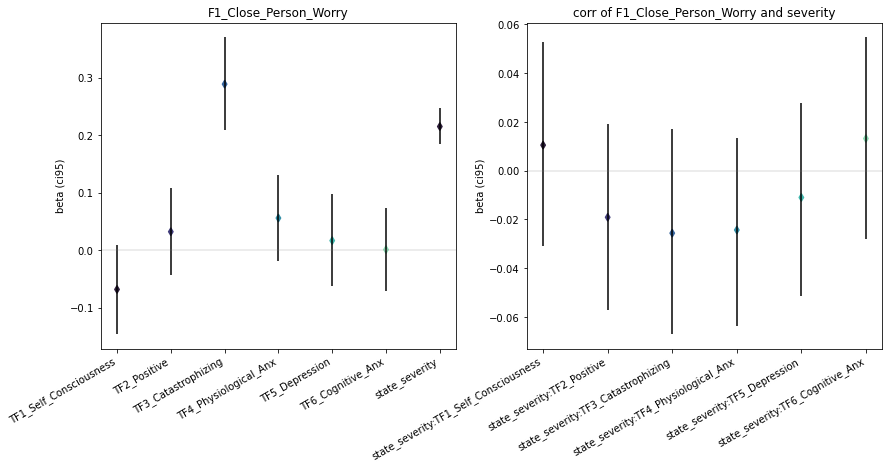

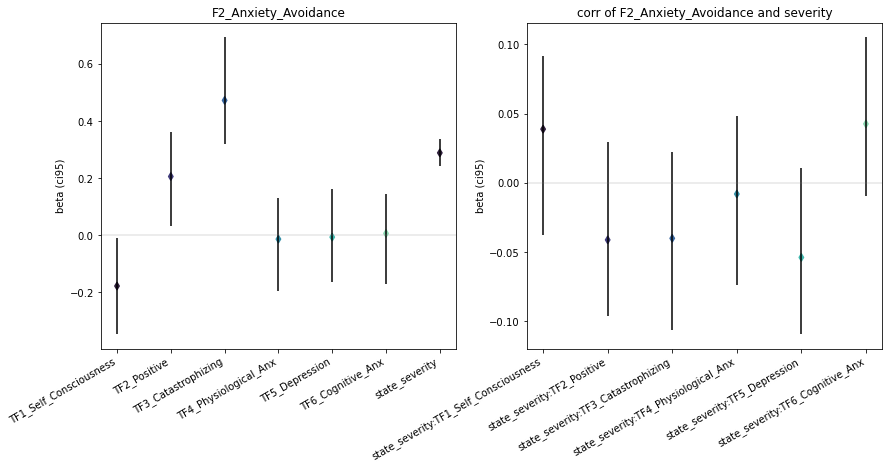

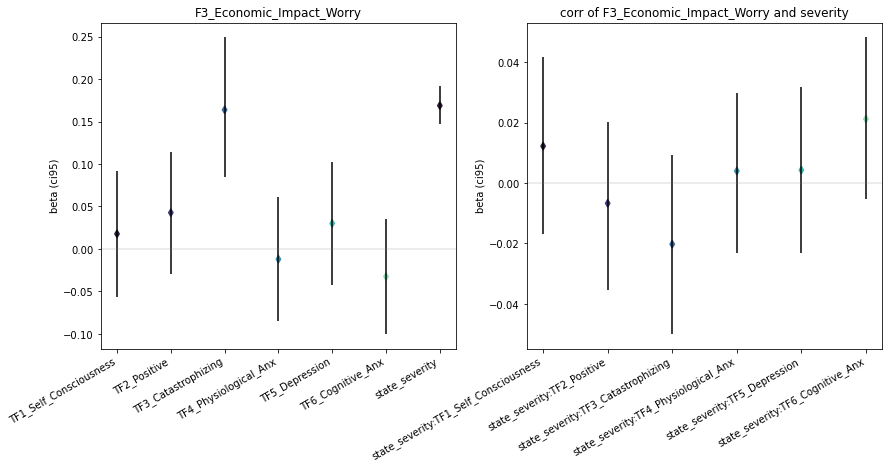

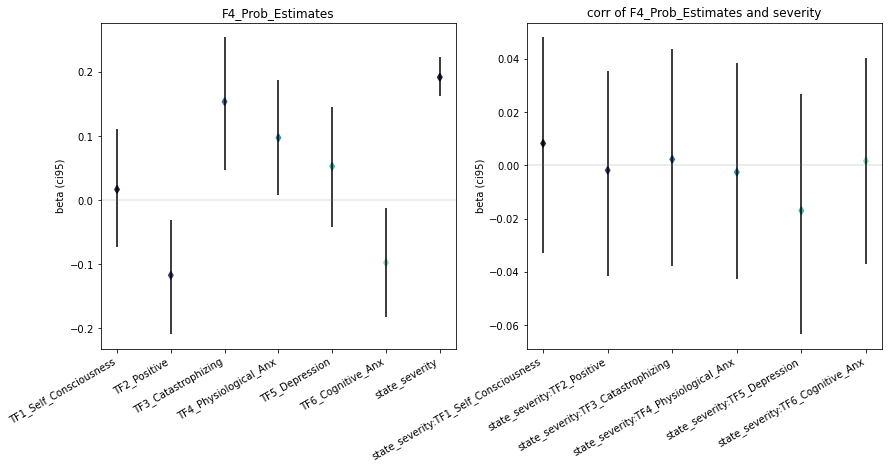

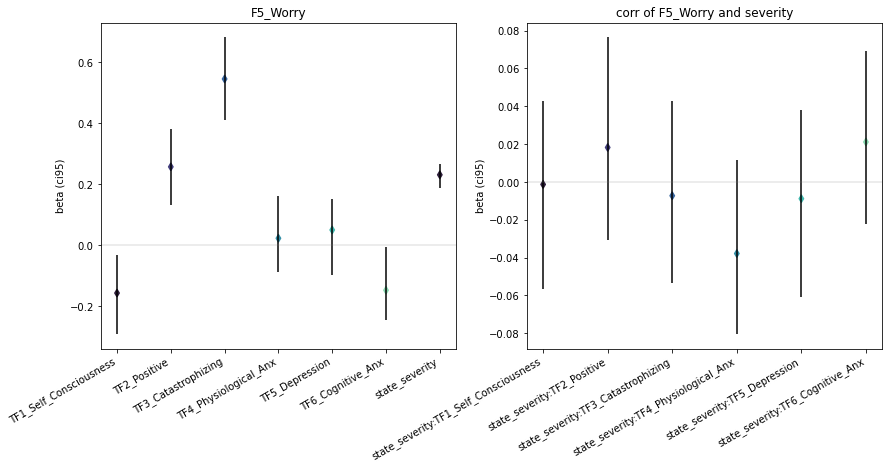

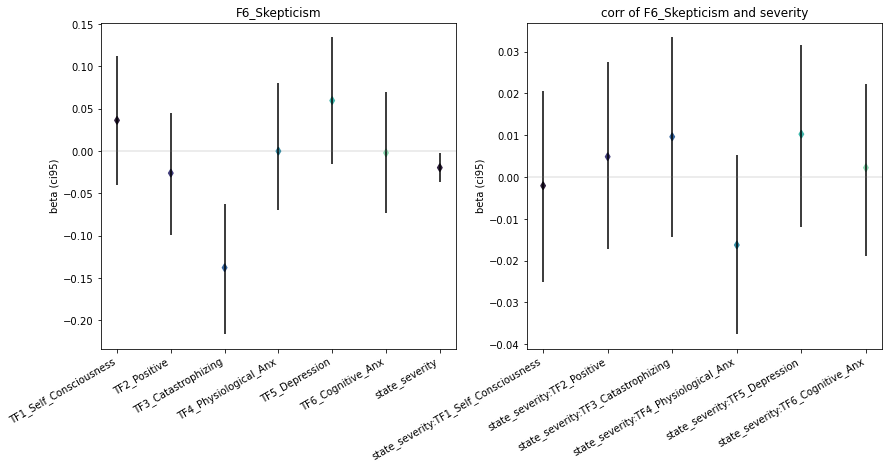

In [12]:

model_constant = "severity_maxmodel_ND"
folder = "traits_predicting_severity_correlations"
for f_idx, f in enumerate(factors): 
    models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
    mod = models["F"+str(f_idx+1)+"_"+model_constant+"_4_3000"]
    # assumes that models have been estimated
    mod["current_sys_location"] = os.path.join(root_dir, mod["location"])
    mod, res, m = mm.estimate_lmm(mod, [], override=0)
    # add diagnostics
    #az.plot_trace(res)
    display.display(az.summary(res).head(15))

    # PLOT
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    for gr_idx, beta_group in enumerate([trait_factor_names+['state_severity'],['state_severity:'+i for i in trait_factor_names]]):
        tdf = pd.DataFrame()
        for tf in beta_group:
            d = res.posterior[tf].stack(draws=("chain", "draw"))
            dt = pd.DataFrame(d, columns=["sample"])
            dt.loc[:,"trait_factor"] = tf
            tdf = pd.concat([tdf, dt])
        tdf
        axs[gr_idx] = sns.pointplot(x="trait_factor", y= "sample",
                      data=tdf, dodge=.532, join=False, palette=sns.color_palette("mako",6),
                      markers="d", scale=.75, ci=None, ax =axs[gr_idx]);
        bounds = tdf.groupby("trait_factor")['sample'].quantile((0.025,0.975)).unstack().reset_index().sort_values(by="trait_factor")
        axs[gr_idx].vlines(bounds.trait_factor, bounds.iloc[:,1], bounds.iloc[:,2], colors='black')
        axs[gr_idx].axhline(0, alpha=0.2, color='gray')
        if gr_idx == 0:
            axs[gr_idx].set_title(f)
        elif gr_idx == 1:
            axs[gr_idx].set_title("corr of "+f+" and severity")
        axs[gr_idx].set_ylabel("beta (ci95)")
        axs[gr_idx].set_xlabel("")
        axs[gr_idx].set_xticklabels(beta_group, rotation = 30, ha="right")

### Model4: No random slopes (except session) but session as fixed    
### *severity + trait + trait\*sess + (sess|subejct)*


In [1]:
ylims = [[-1,1], [-0.3, 0.3], [-0.02, 0.02]]
model_constant = "severity_slopes_and_session_ND"
folder = "traits_predicting_severity_correlations"
for f_idx, f in enumerate(factors): 
    models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
    mod = models["F"+str(f_idx+1)+"_"+model_constant+"_4_3000"]
    # assumes that models have been estimated
    mod["current_sys_location"] = os.path.join(root_dir, mod["location"])
    print(mod["current_sys_location"])
    mod, res, m = mm.estimate_lmm(mod, [], override=0)
    # add diagnostics
    #az.plot_trace(res)
    display.display(az.summary(res).head(15))

    # PLOT
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    for gr_idx, beta_group in enumerate([trait_factor_names+['state_severity'],
                                        ['state_severity:'+i for i in trait_factor_names],
                                        ['state_severity:'+i+":session" for i in trait_factor_names]]):
        tdf = pd.DataFrame()
        for tf in beta_group:
            d = res.posterior[tf].stack(draws=("chain", "draw"))
            dt = pd.DataFrame(d, columns=["sample"])
            dt.loc[:,"trait_factor"] = tf
            tdf = pd.concat([tdf, dt])
        tdf
        axs[gr_idx] = sns.pointplot(x="trait_factor", y= "sample",
                      data=tdf, dodge=.532, join=False, palette=sns.color_palette("mako",6),
                      markers="d", scale=.75, ci=None, ax =axs[gr_idx]);
        bounds = tdf.groupby("trait_factor")['sample'].quantile((0.025,0.975)).unstack().reset_index().sort_values(by="trait_factor")
        axs[gr_idx].vlines(bounds.trait_factor, bounds.iloc[:,1], bounds.iloc[:,2], colors='black')
        axs[gr_idx].axhline(0, alpha=0.2, color='gray')
        if gr_idx == 0:
            axs[gr_idx].set_title(f)
        elif gr_idx == 1:
            axs[gr_idx].set_title("corr of "+f+" and severity")
        axs[gr_idx].set_ylabel("beta (ci95)")
        axs[gr_idx].set_xlabel("")
        axs[gr_idx].set_xticklabels(beta_group, rotation = 30, ha="right")
        axs[gr_idx].set_ylim(ylims[gr_idx])

NameError: name 'factors' is not defined

### Model comparison 

**NOTE (!)** higher WAIC/LOO values are better - see Vehtari et al 2017 or https://arviz-devs.github.io/arviz/api/generated/arviz.compare.html#arviz.compare 


Model F1_severity_noslope_ND_4_3000 already exist, loading it.
Model F1_severity_slopes_ND_4_3000 already exist, loading it.
Model F1_severity_maxmodel_ND_4_3000 already exist, loading it.
Model F1_severity_slopes_and_session_ND_4_3000 already exist, loading it.


rank         waic      p_waic      d_waic        weight  \
maximal          0 -1601.324230  591.411441    0.000000  9.811453e-01   
slopes           1 -1605.276187  593.306106    3.951957  1.885473e-02   
session_ints     2 -1724.053851  461.061442  122.729621  4.908356e-54   
noslopes         3 -1753.192316  470.202639  151.868086  1.087080e-66   

                     se        dse  warning waic_scale  
maximal       69.517629   0.000000     True        log  
slopes        69.721622   2.975233     True        log  
session_ints  69.249922  20.851599     True        log  
noslopes      69.551964  20.682243     True        log

Model F2_severity_noslope_ND_4_3000 already exist, loading it.
Model F2_severity_slopes_ND_4_3000 already exist, loading it.
Model F2_severity_maxmodel_ND_4_3000 already exist, loading it.
Model F2_severity_slopes_and_session_ND_4_3000 already exist, loading it.


rank         waic      p_waic      d_waic        weight  \
slopes           0 -3729.013184  609.611030    0.000000  6.622943e-01   
maximal          1 -3729.686719  600.901984    0.673535  3.377057e-01   
session_ints     2 -3881.556319  491.821270  152.543135  3.736020e-67   
noslopes         3 -3884.288112  495.364860  155.274928  2.432242e-68   

                     se        dse  warning waic_scale  
slopes        97.653544   0.000000     True        log  
maximal       97.536452   9.569827     True        log  
session_ints  92.047875  22.308457     True        log  
noslopes      92.362029  21.672798     True        log

Model F3_severity_noslope_ND_4_3000 already exist, loading it.
Model F3_severity_slopes_ND_4_3000 already exist, loading it.
Model F3_severity_maxmodel_ND_4_3000 already exist, loading it.
Model F3_severity_slopes_and_session_ND_4_3000 already exist, loading it.


rank        waic      p_waic      d_waic        weight  \
slopes           0 -117.049507  582.817280    0.000000  9.697629e-01   
maximal          1 -120.517488  595.796017    3.467981  3.023712e-02   
session_ints     2 -222.112352  473.277700  105.062845  2.282716e-46   
noslopes         3 -244.566160  477.813799  127.516653  4.044703e-56   

                     se        dse  warning waic_scale  
slopes        69.325640   0.000000     True        log  
maximal       69.588436   3.634602     True        log  
session_ints  69.449701  19.966218     True        log  
noslopes      70.122716  19.982191     True        log

Model F4_severity_noslope_ND_4_3000 already exist, loading it.
Model F4_severity_slopes_ND_4_3000 already exist, loading it.
Model F4_severity_maxmodel_ND_4_3000 already exist, loading it.
Model F4_severity_slopes_and_session_ND_4_3000 already exist, loading it.


rank        waic      p_waic      d_waic         weight  \
slopes           0 -718.558455  630.638227    0.000000   9.999986e-01   
maximal          1 -732.003220  650.356349   13.444765   1.448812e-06   
session_ints     2 -939.176657  506.268356  220.618202   1.537205e-96   
noslopes         3 -958.696687  505.322345  240.138232  5.120239e-105   

                     se        dse  warning waic_scale  
slopes        79.315640   0.000000     True        log  
maximal       79.473418   6.622094     True        log  
session_ints  76.261164  26.392171     True        log  
noslopes      75.506485  26.649758     True        log

Model F5_severity_noslope_ND_4_3000 already exist, loading it.
Model F5_severity_slopes_ND_4_3000 already exist, loading it.
Model F5_severity_maxmodel_ND_4_3000 already exist, loading it.
Model F5_severity_slopes_and_session_ND_4_3000 already exist, loading it.


rank         waic      p_waic      d_waic        weight  \
maximal          0 -2693.944636  599.660179    0.000000  9.999999e-01   
slopes           1 -2710.076677  609.128675   16.132041  9.861509e-08   
session_ints     2 -2806.498006  479.538087  112.553370  1.314294e-49   
noslopes         3 -2850.144960  485.102616  156.200325  1.455663e-68   

                     se        dse  warning waic_scale  
maximal       79.002393   0.000000     True        log  
slopes        77.216216   6.790532     True        log  
session_ints  76.185871  21.698005     True        log  
noslopes      77.091940  21.892049     True        log

Model F6_severity_noslope_ND_4_3000 already exist, loading it.
Model F6_severity_slopes_ND_4_3000 already exist, loading it.
Model F6_severity_maxmodel_ND_4_3000 already exist, loading it.
Model F6_severity_slopes_and_session_ND_4_3000 already exist, loading it.


rank        waic      p_waic     d_waic        weight  \
maximal          0  733.242460  601.444875   0.000000  7.650870e-01   
slopes           1  732.061686  600.162371   1.180774  2.349130e-01   
session_ints     2  652.308540  506.139091  80.933920  5.426951e-36   
noslopes         3  649.540224  502.751106  83.702236  3.406368e-37   

                     se        dse  warning waic_scale  
maximal       73.275796   0.000000     True        log  
slopes        73.223359   2.885118     True        log  
session_ints  72.231304  16.219719     True        log  
noslopes      72.300641  15.841341     True        log

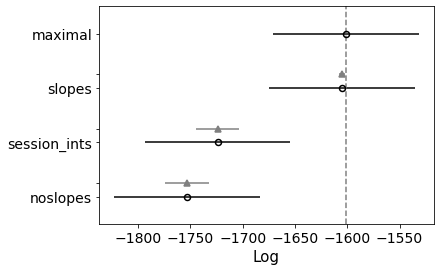

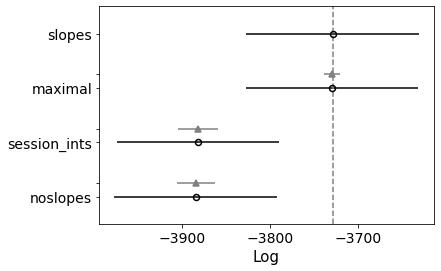

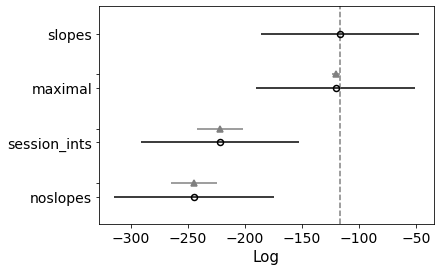

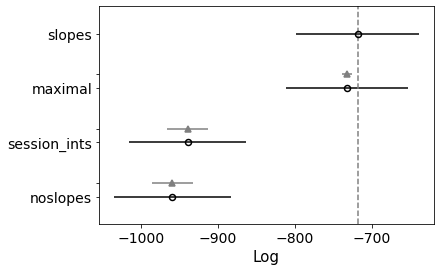

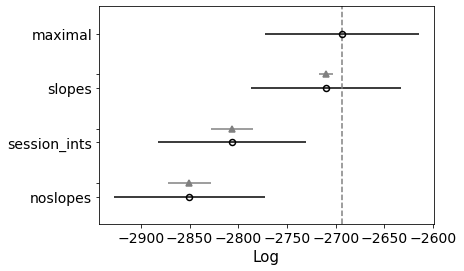

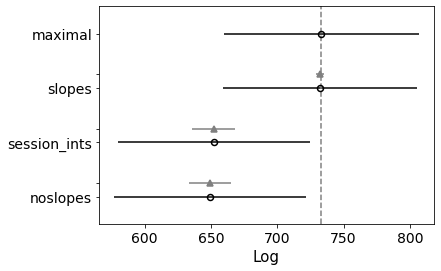

In [7]:
model_constants = ["severity_noslope",  "severity_maxmodel"]
folder = "traits_predicting_severity_correlations"
models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
for f_idx, f in enumerate(factors):    
    mod1 = models["F"+str(f_idx+1)+"_severity_noslope_ND_4_3000"]
    mod1["current_sys_location"] = os.path.join(root_dir, mod1["location"])
    mod1, res_m1, m = mm.estimate_lmm(mod1, [], override=0)
    
    mod2 = models["F"+str(f_idx+1)+"_severity_slopes_ND_4_3000"]
    mod2["current_sys_location"] = os.path.join(root_dir, mod2["location"])
    mod2, res_m2, m = mm.estimate_lmm(mod2, [], override=0)
    
    mod3 = models["F"+str(f_idx+1)+"_severity_maxmodel_ND_4_3000"]
    mod3["current_sys_location"] = os.path.join(root_dir, mod3["location"])
    mod3, res_m3, m = mm.estimate_lmm(mod3, [], override=0)
    
    mod4 = models["F"+str(f_idx+1)+"_severity_slopes_and_session_ND_4_3000"]
    mod4["current_sys_location"] = os.path.join(root_dir, mod4["location"])
    mod4, res_m4, m = mm.estimate_lmm(mod4, [], override=0)
    
    comp = az.compare({"noslopes": res_m1, "slopes": res_m2, "maximal": res_m3, "session_ints": res_m4}, ic="waic",method="pseudo-BMA")
    display.display(comp)
    az.plot_compare(comp, insample_dev=False);

### example of prior distributions

In [2]:
eq = mod["lmm"]["eq"]
m = bmb.Model(eq, dfl, family="gaussian", link="identity")
m.build()
prior = m.prior_predictive(1000)

NameError: name 'mod' is not defined

In [ ]:
# plot prior
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
for gr_idx, beta_group in enumerate([trait_factor_names+['state_severity'],
                                    ['state_severity:'+i for i in trait_factor_names],
                                    ['state_severity:'+i+":session" for i in trait_factor_names]]):
    tdf = pd.DataFrame()
    for tf in beta_group:
        d = prior.prior[tf].stack(draws=("chain", "draw"))
        dt = pd.DataFrame(d, columns=["sample"])
        dt.loc[:,"trait_factor"] = tf
        tdf = pd.concat([tdf, dt])
    tdf
    axs[gr_idx] = sns.pointplot(x="trait_factor", y= "sample",
                  data=tdf, dodge=.532, join=False, palette=sns.color_palette("mako",6),
                  markers="d", scale=.75, ci=None, ax =axs[gr_idx]);
    bounds = tdf.groupby("trait_factor")['sample'].quantile((0.025,0.975)).unstack().reset_index().sort_values(by="trait_factor")
    axs[gr_idx].vlines(bounds.trait_factor, bounds.iloc[:,1], bounds.iloc[:,2], colors='black')
    axs[gr_idx].axhline(0, alpha=0.2, color='gray')
    if gr_idx == 0:
        axs[gr_idx].set_title(f)
    elif gr_idx == 1:
        axs[gr_idx].set_title("corr of "+f+" and severity")
    axs[gr_idx].set_ylabel("beta (ci95)")
    axs[gr_idx].set_xlabel("")
    axs[gr_idx].set_xticklabels(beta_group, rotation = 30, ha="right")
    #axs[gr_idx].set_ylim(ylims[gr_idx])